In [1]:
import os, gc, re, time, pickle
from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
os.listdir('../data/input')

['calendar.csv',
 'data.pkl',
 'prep_data.pkl',
 'sales_train_validation.csv',
 'sample_submission.csv',
 'sell_prices.csv']

In [3]:
%%time
with open('../data/input/data.pkl', 'rb') as f:
    df = pickle.load(f)

Wall time: 1min 43s


In [4]:
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  demand   part       date  wm_yr_wk event_name_1 event_type_1  \
0       CA       0  train 2011-01-29     11101          NaN          NaN   
1       CA       0  train 2011-01-29     11101          NaN          NaN   
2       CA       0  train 2011-01-29     11101          NaN          NaN   
3       CA       0  train 2011-01-29     11101          NaN          NaN   
4       CA       0  train 2011-01-29     11101          NaN          NaN   

  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  sell_price  
0          NaN          NaN        0        0        0         NaN  
1          NaN          NaN        0        0        0         NaN  
2          NaN          NaN        0        0        0         NaN  
3          NaN          NaN        0        0        0         NaN  
4          NaN          NaN        0        0        0         NaN

In [5]:
print(df[df['part'] == 'train']['date'].min())
print(df[df['part'] == 'train']['date'].max())

2011-01-29 00:00:00
2016-04-24 00:00:00


In [6]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

In [7]:
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  demand   part       date  wm_yr_wk event_name_1 event_type_1  \
0       CA       0  train 2011-01-29     11101          NaN          NaN   
1       CA       0  train 2011-01-29     11101          NaN          NaN   
2       CA       0  train 2011-01-29     11101          NaN          NaN   
3       CA       0  train 2011-01-29     11101          NaN          NaN   
4       CA       0  train 2011-01-29     11101          NaN          NaN   

  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  sell_price  year  \
0          NaN          NaN        0        0        0         NaN  2011   
1          NaN          NaN        0        0        0         NaN  2011   
2          NaN          NaN        0        0        0         NaN  2011   
3          NaN          NaN        0        0        0         NaN  2011   
4          NaN          NaN        0        0        0         NaN  2011   

   month  weekday  
0      1        5  
1      1        5  
2      1        5  
3      1        5  
4      1        5

In [8]:
# Label
event_col = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for c in event_col:
    df[c] = df[c].fillna('Nodata')
    df[c + '_l'] = df[c].apply(lambda x: 0 if x == 'Nodata' else -1)

In [9]:
train = df[df['part'] == 'train']
# val = df[df['part'] == 'test1']
# eval = df[df['part'] == 'test2']
del df
gc.collect()

22

---
## Date

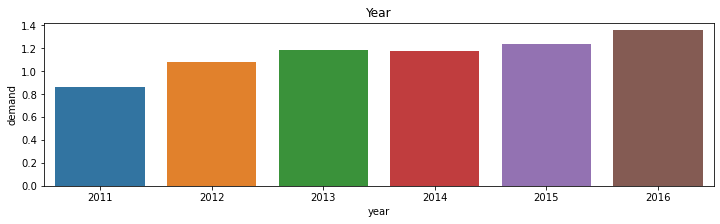

In [10]:
# Year
group = train.groupby(['year'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.barplot(x='year', y='demand', data=group)
plt.title('Year')
plt.show()

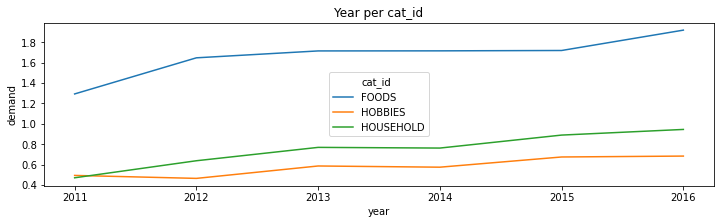

In [11]:
# Year, cat_id
group = train.groupby(['year', 'cat_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='year', y='demand', hue='cat_id', data=group)
plt.title('Year per cat_id')
plt.show()

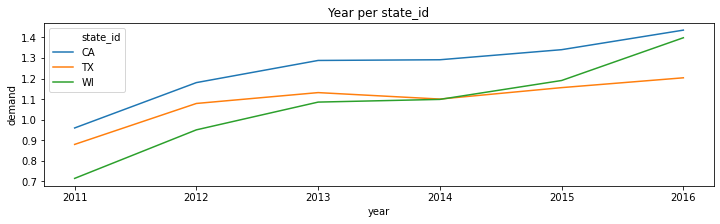

In [12]:
group = train.groupby(['year', 'state_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='year', y='demand', hue='state_id', data=group)
plt.title('Year per state_id')
plt.show()

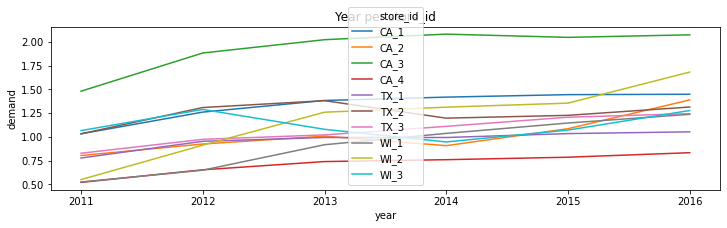

In [13]:
group = train.groupby(['year', 'store_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='year', y='demand', hue='store_id', data=group)
plt.title('Year per store_id')
plt.show()

---
Month

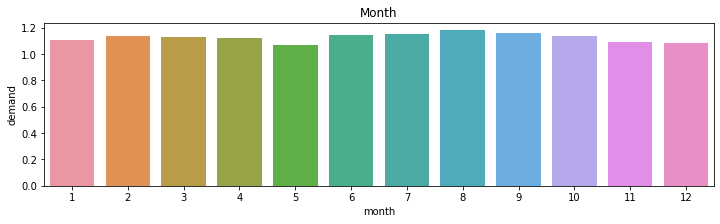

In [14]:
group = train.groupby(['month'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.barplot(x='month', y='demand', data=group)
plt.title('Month')
plt.show()

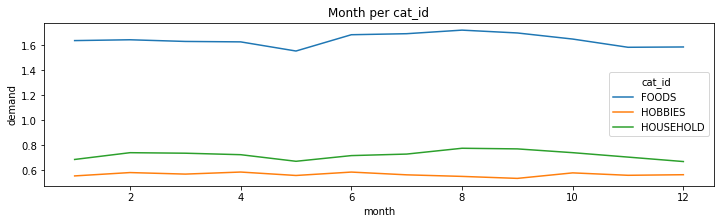

In [15]:
group = train.groupby(['month', 'cat_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='month', y='demand', hue='cat_id', data=group)
plt.title('Month per cat_id')
plt.show()

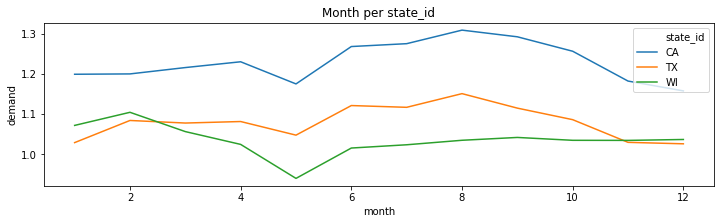

In [16]:
group = train.groupby(['month', 'state_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='month', y='demand', hue='state_id', data=group)
plt.title('Month per state_id')
plt.show()

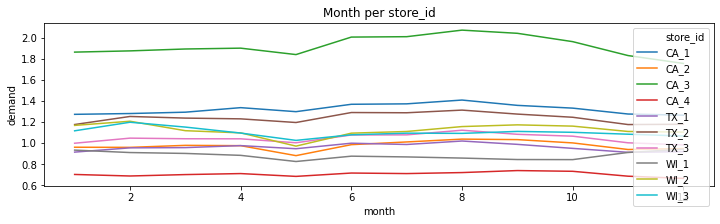

In [17]:
group = train.groupby(['month', 'store_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='month', y='demand', hue='store_id', data=group)
plt.title('Month per store_id')
plt.show()

---
Weekday

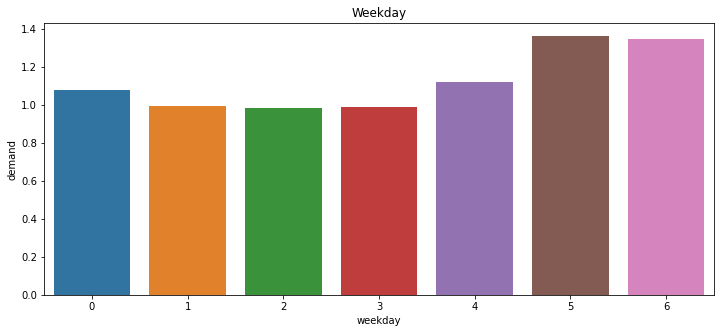

In [18]:
group = train.groupby(['weekday'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 5), facecolor='w')
sns.barplot(x='weekday', y='demand', data=group)
plt.title('Weekday')
plt.show()

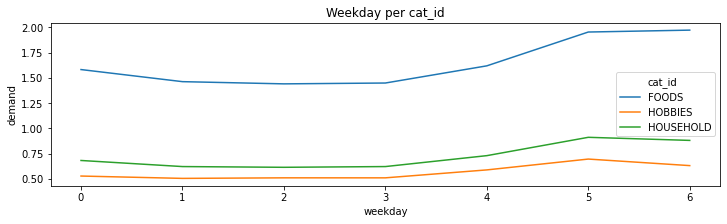

In [19]:
group = train.groupby(['weekday', 'cat_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='weekday', y='demand', hue='cat_id', data=group)
plt.title('Weekday per cat_id')
plt.show()

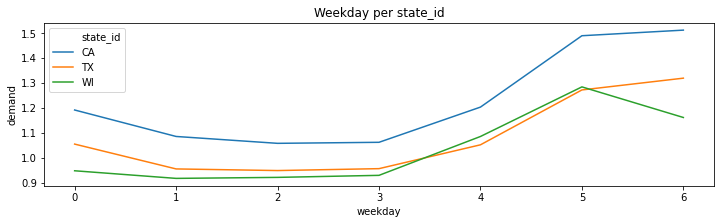

In [20]:
group = train.groupby(['weekday', 'state_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='weekday', y='demand', hue='state_id', data=group)
plt.title('Weekday per state_id')
plt.show()

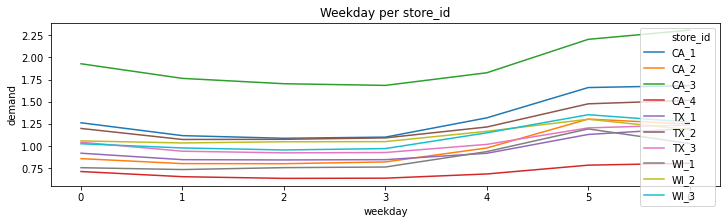

In [21]:
group = train.groupby(['weekday', 'store_id'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
sns.lineplot(x='weekday', y='demand', hue='store_id', data=group)
plt.title('Weekday per store_id')
plt.show()

In [109]:
print(train[train['event_type_1_l'] != 0]['date'].nunique())
print(train['date'].nunique())

154
1913


---
## Plot

In [119]:
def plot(df, id):
    """
    IDごとのプロット
    """
    temp = df[df['id'] == id]
    temp.sort_values(by='date', ascending=True, inplace=True)
    
    fig, ax1 = plt.subplots(figsize=(14, 3), facecolor='w')
    ax2 = ax1.twinx()
    ax1.plot(temp['date'], temp['demand'], color='b', label='demand')
    ax1.plot(temp['date'], temp['event_name_1_l'], color='g', label='isEvent')
    ax2.plot(temp['date'], temp['sell_price'], color='r', label='sell_price')
    # 第２軸の範囲を設定
    ax2.set_ylim(temp['sell_price'].min() - 0.5, temp['sell_price'].max() + 0.5)
    # 凡例
    # グラフの本体設定時に、ラベルを手動で設定する必要があるのは、barplotのみ。plotは自動で設定される＞
    handler1, label1 = ax1.get_legend_handles_labels()
    handler2, label2 = ax2.get_legend_handles_labels()
    # 凡例をまとめて出力する
    ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
    plt.title(id)
    plt.show()
    
    
def plot_per_item(df, item):
    """
    item_idを入れるとstoreごとのプロットを抽出する
    """
    
    tar_col = [c for c in df['id'].values if item in c]
    
    fig, axes = plt.subplots(5, 2, figsize=(12, 18))
    
    for i, (t, ax) in enumerate(zip(tar_col, axes.ravel())):        
        temp = df[df['id'] == t]
        temp.sort_values(by='date', ascending=True, inplace=True)
        
        ax2 = ax.twinx()
        ax.plot(temp['date'], temp['demand'], color='b', label='demand')
        ax.plot(temp['date'], temp['event_name_1_l'], color='g', label='isEvent')
        ax2.plot(temp['date'], temp['sell_price'], color='r', label='sell_price')
        # 第２軸の範囲を設定
        ax2.set_ylim(temp['sell_price'].min() - 0.5, temp['sell_price'].max() + 0.5)
        # 凡例
        # グラフの本体設定時に、ラベルを手動で設定する必要があるのは、barplotのみ。plotは自動で設定される＞
        handler1, label1 = ax.get_legend_handles_labels()
        handler2, label2 = ax2.get_legend_handles_labels()
        # 凡例をまとめて出力する
        ax.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
        ax.set_title(t)
        
    plt.tight_layout()

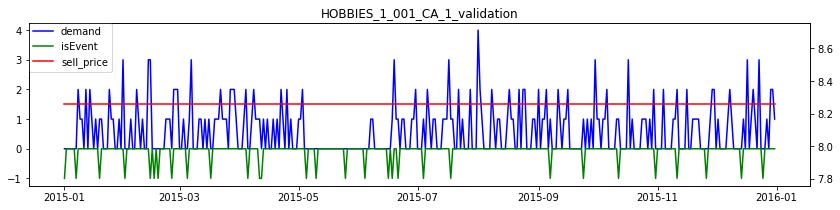

In [116]:
ids = train['id'].unique()
plot(train[train['year'] == 2015], ids[0])

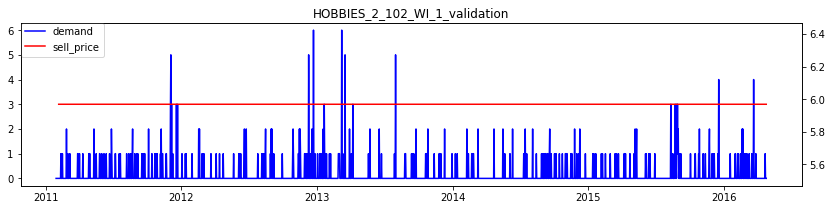

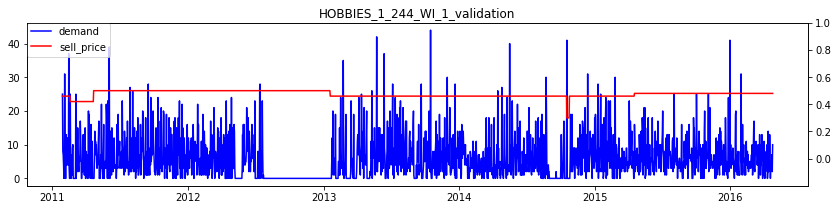

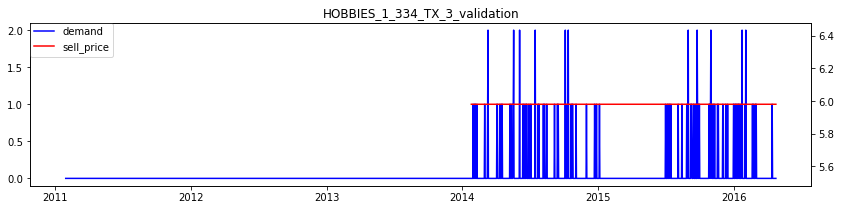

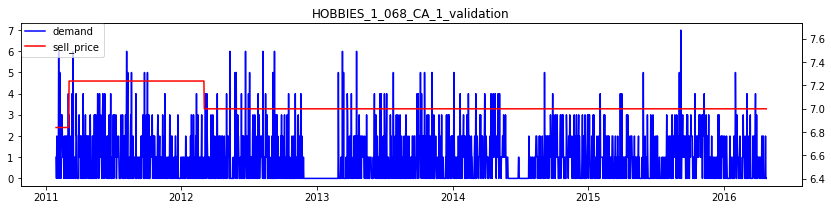

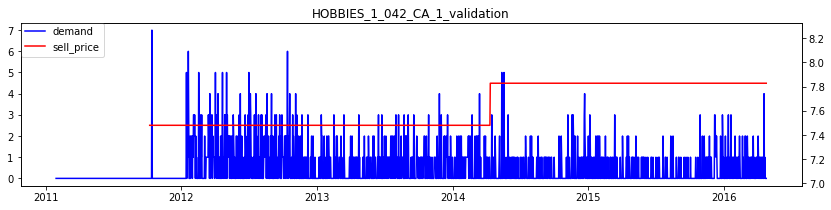

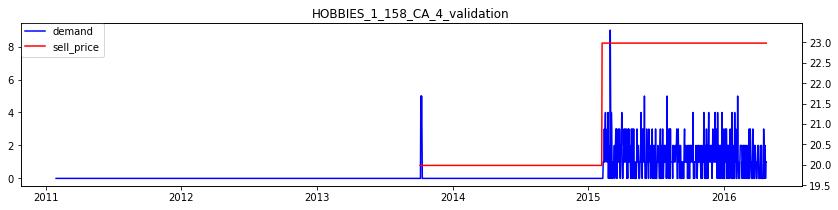

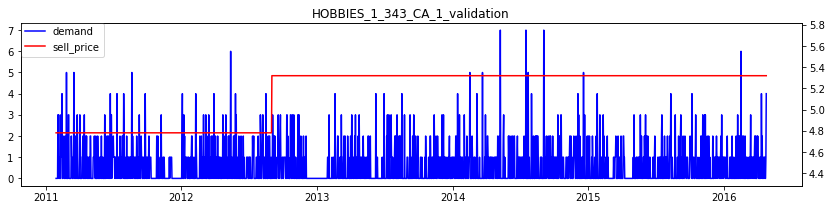

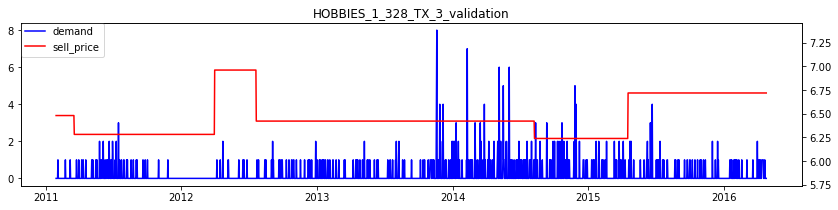

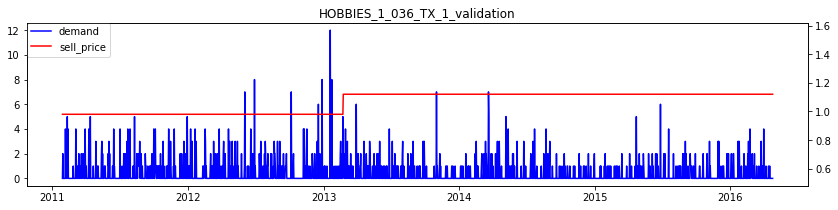

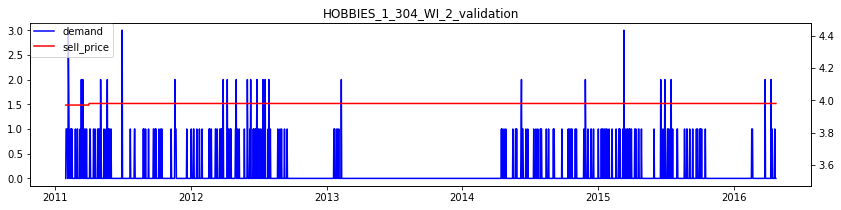

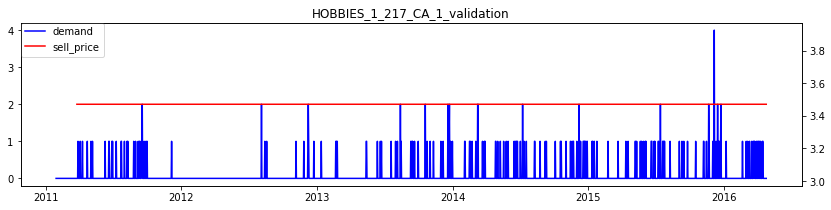

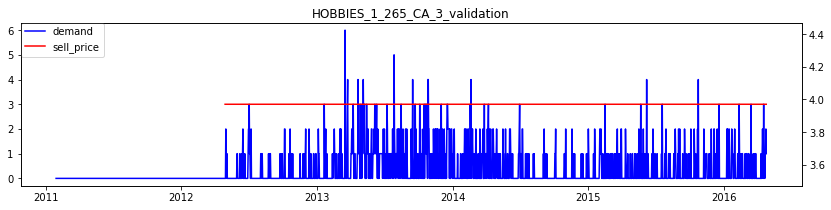

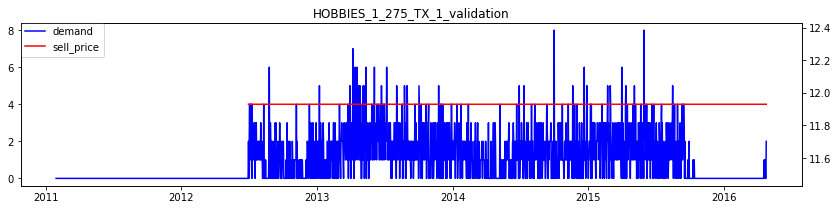

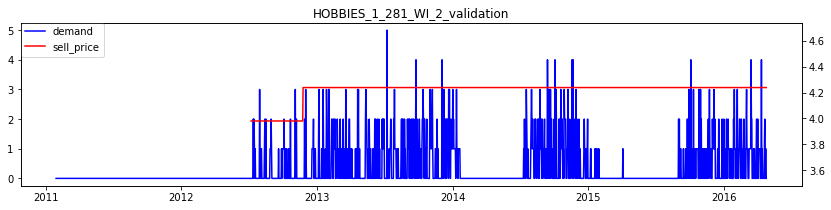

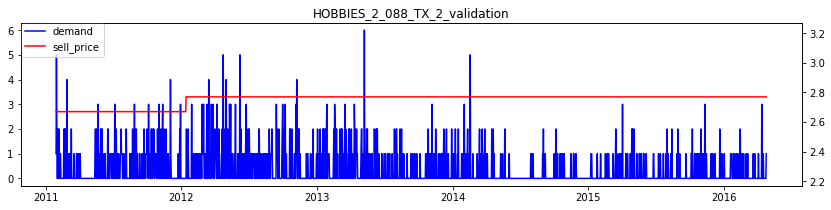

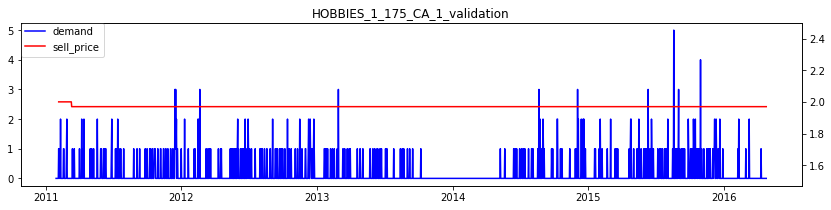

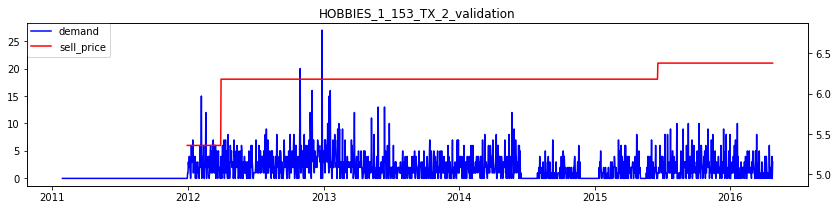

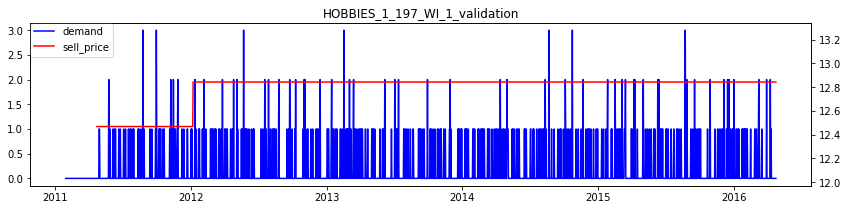

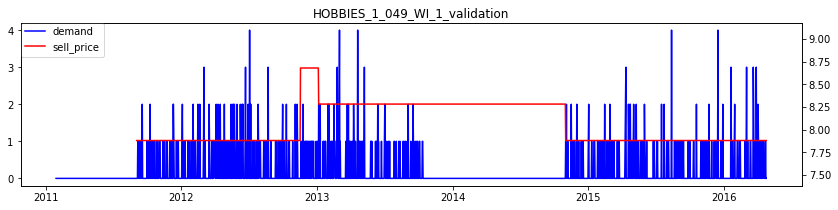

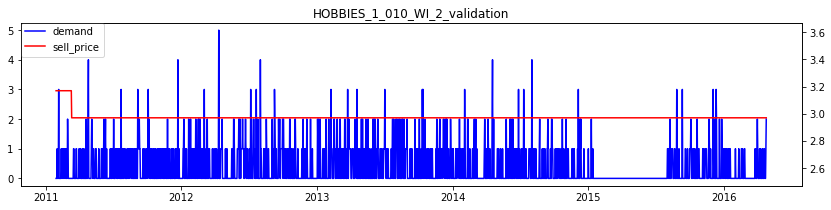

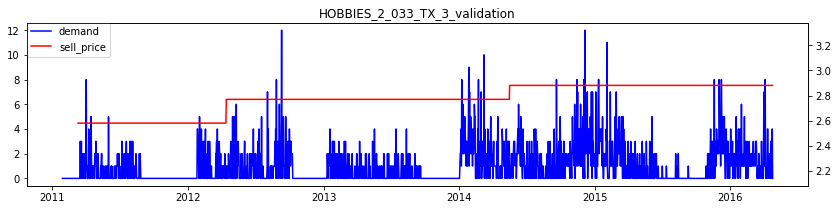

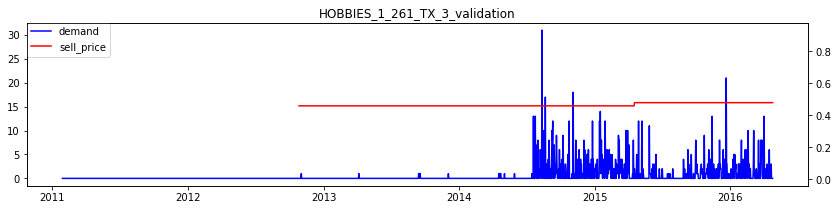

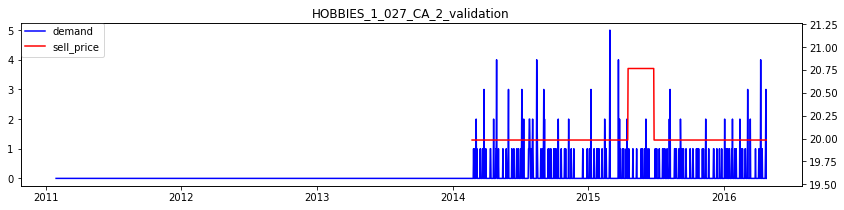

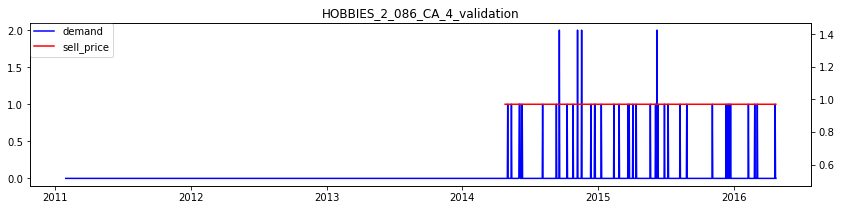

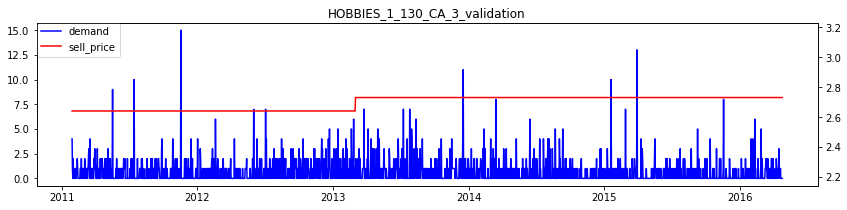

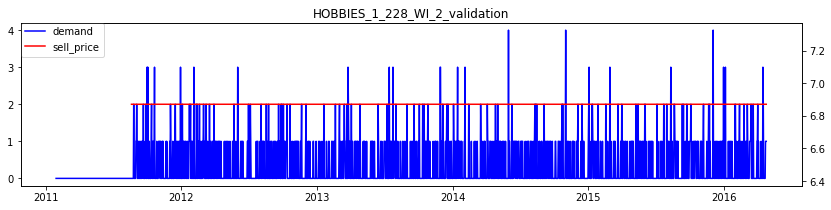

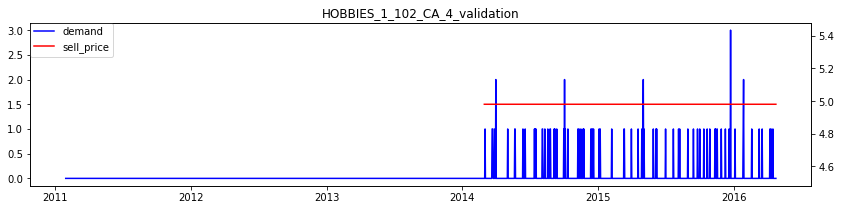

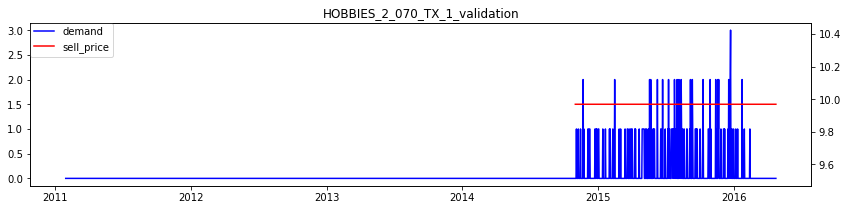

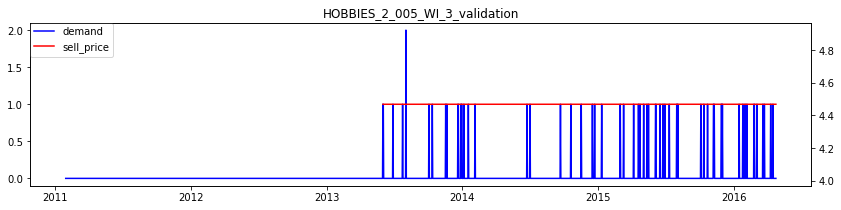

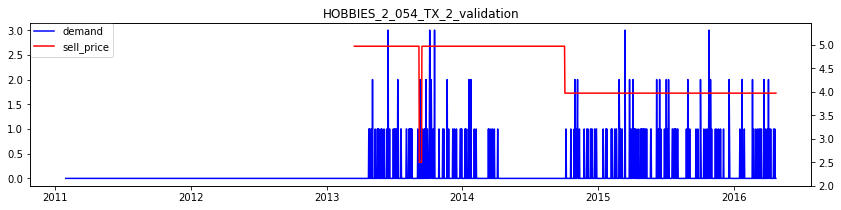

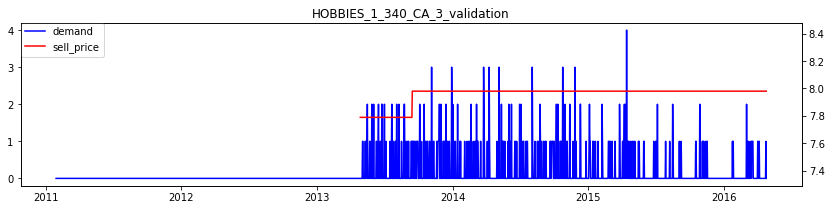

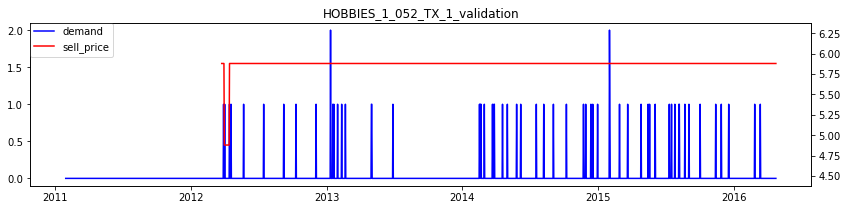

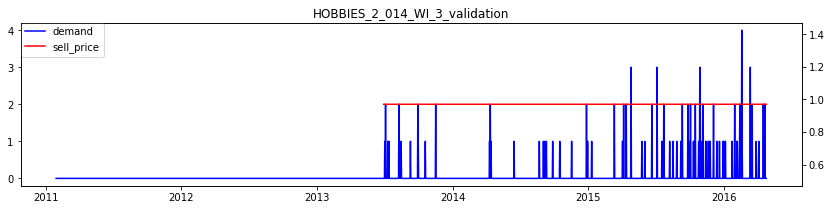

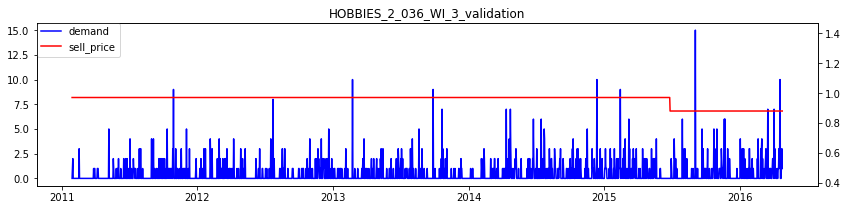

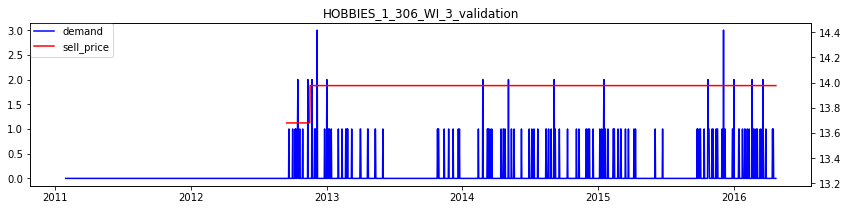

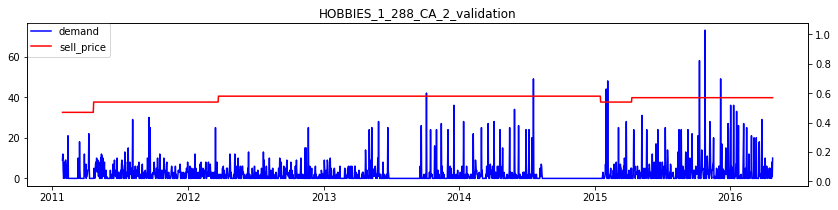

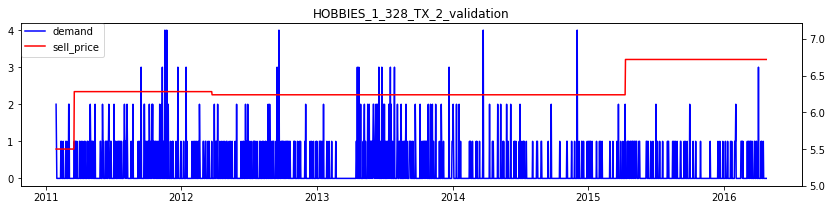

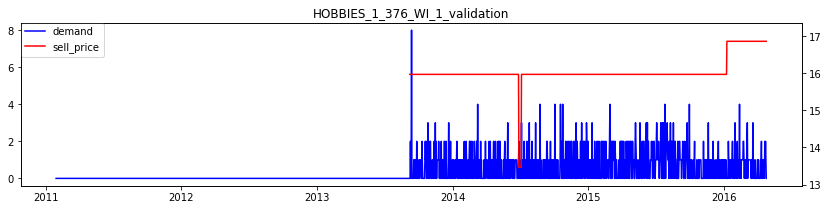

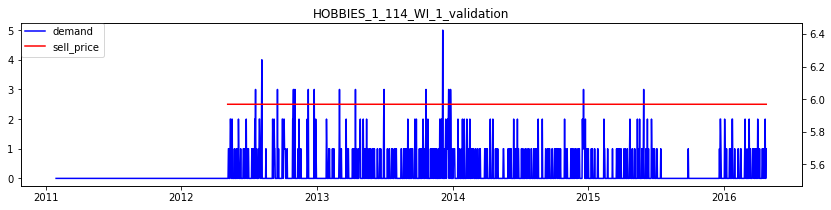

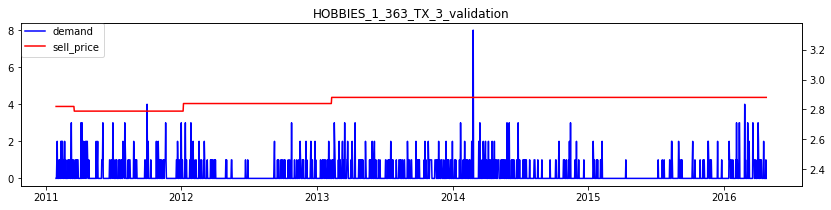

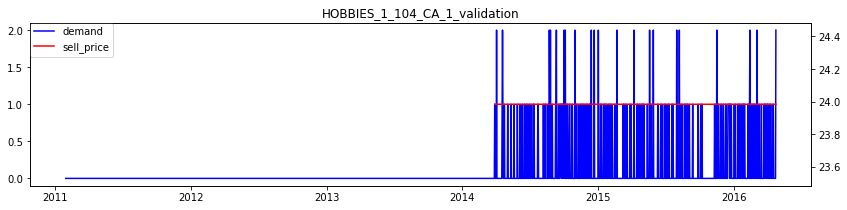

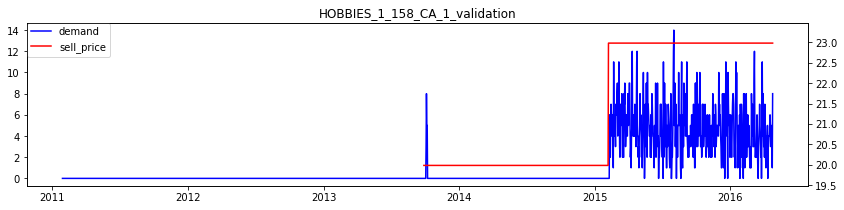

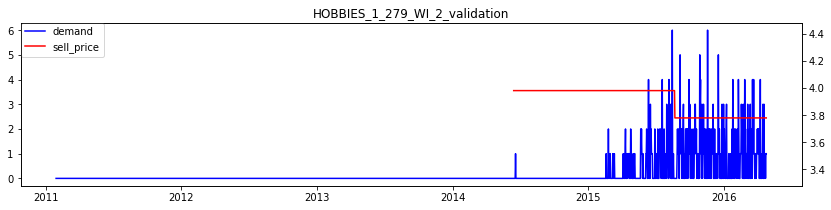

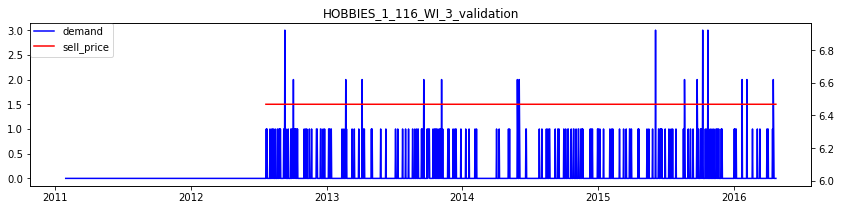

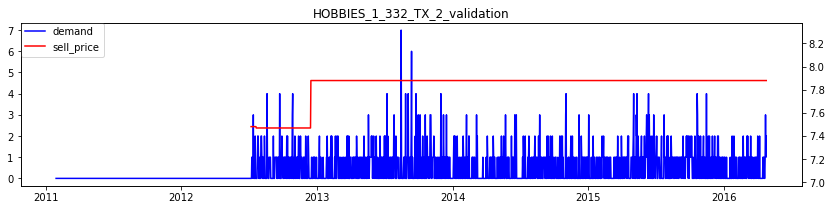

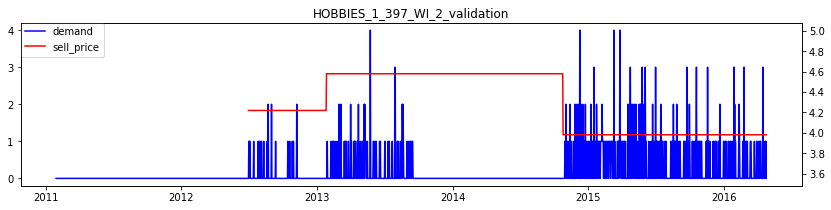

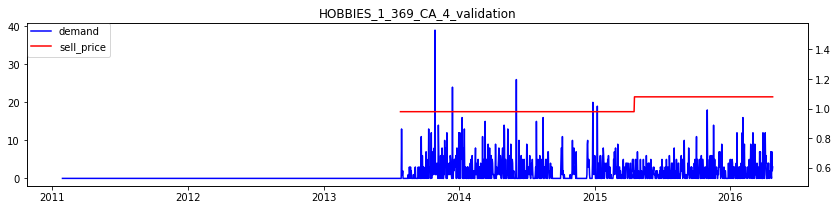

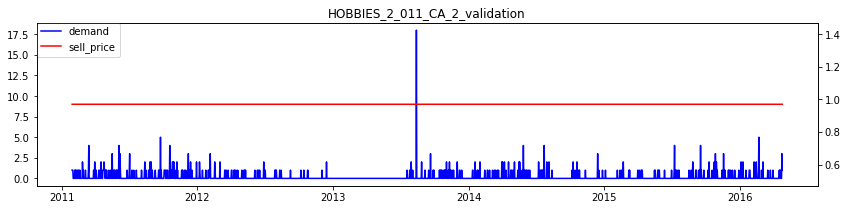

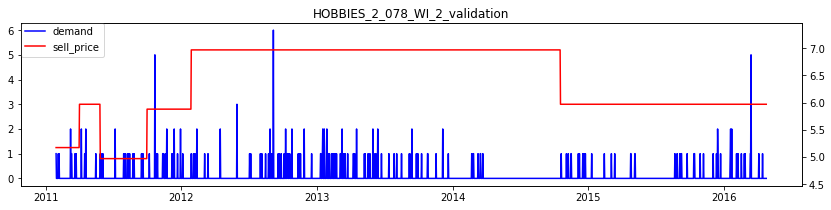

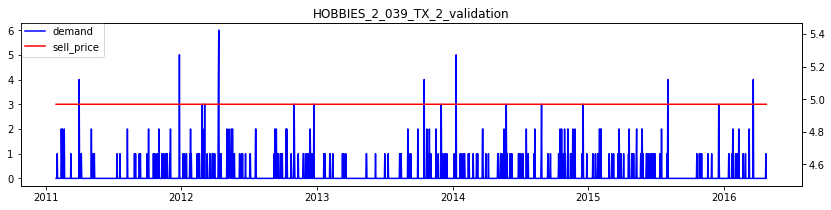

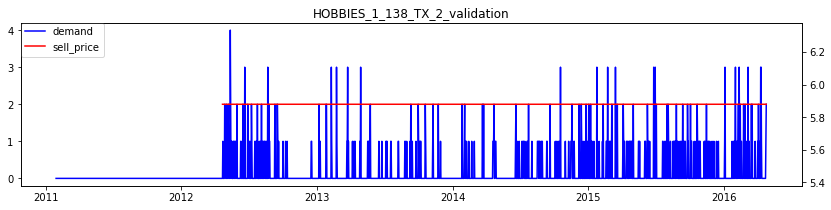

In [87]:
hobbie_id = [id for id in ids if 'HOBBIES' in id]
for i in range(len(hobbie_id)):
    r = np.random.randint(1, len(hobbie_id))
    plot(train, hobbie_id[r])
    if i == 50:
        break

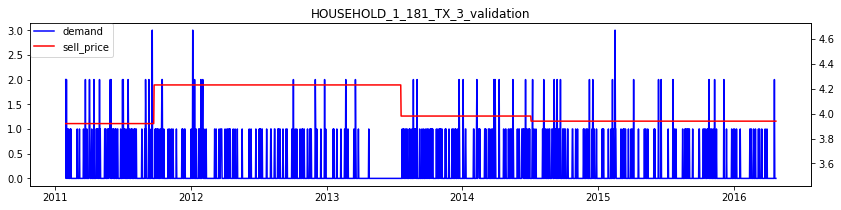

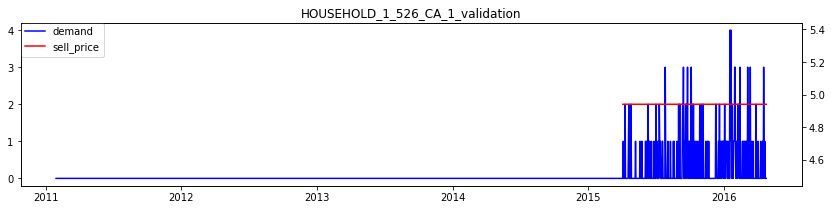

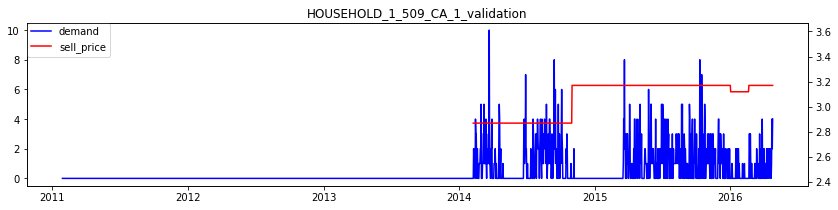

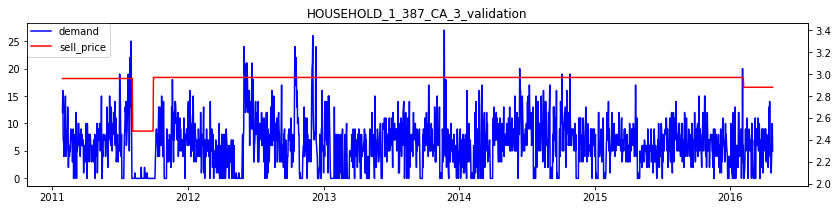

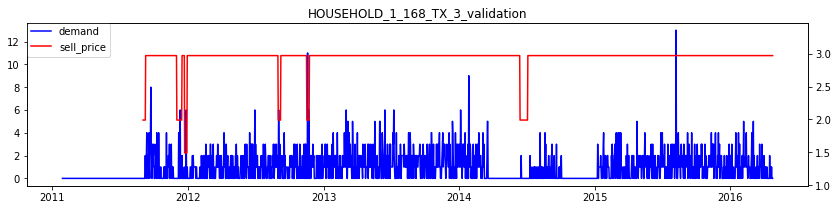

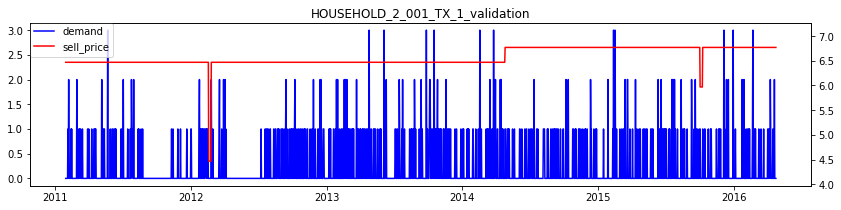

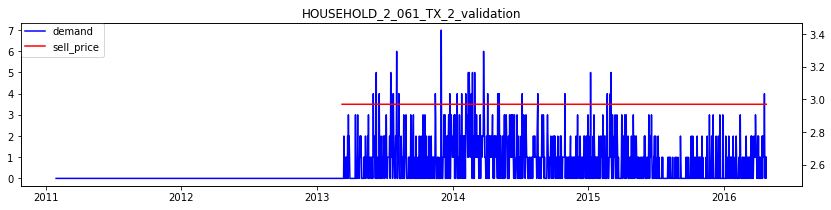

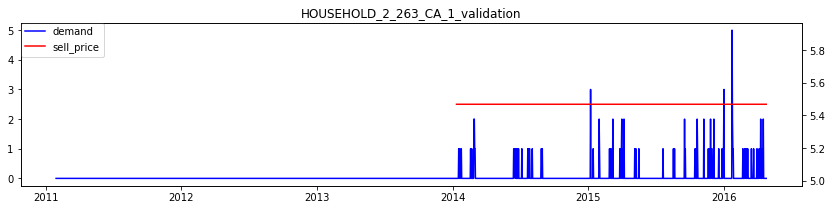

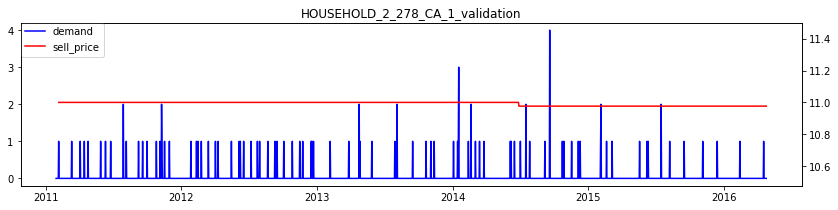

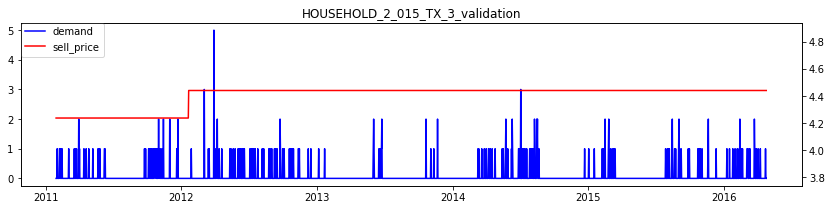

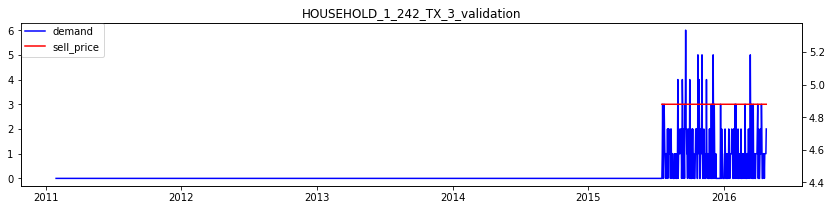

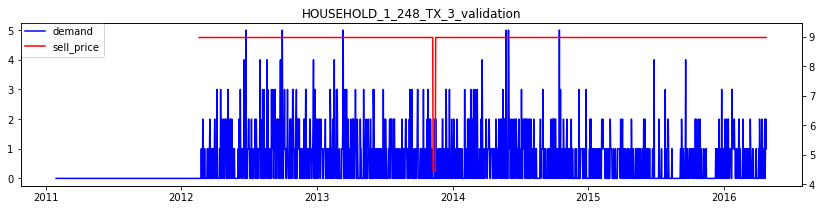

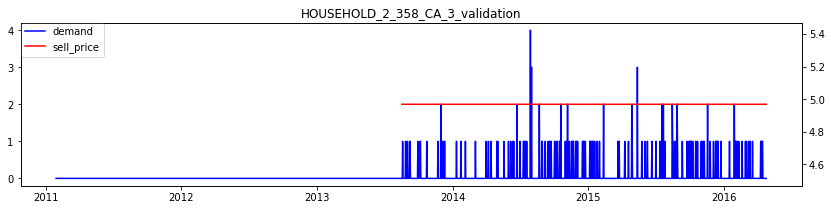

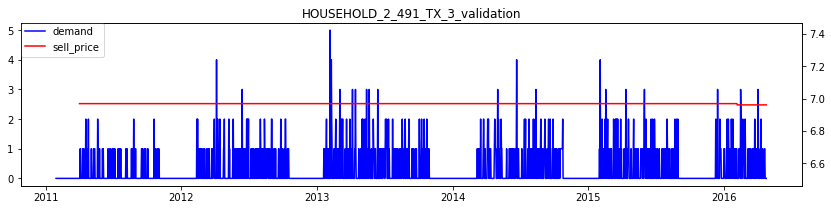

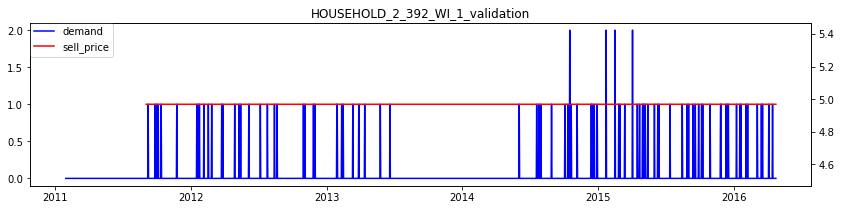

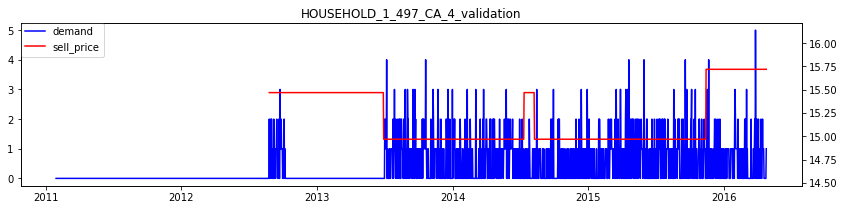

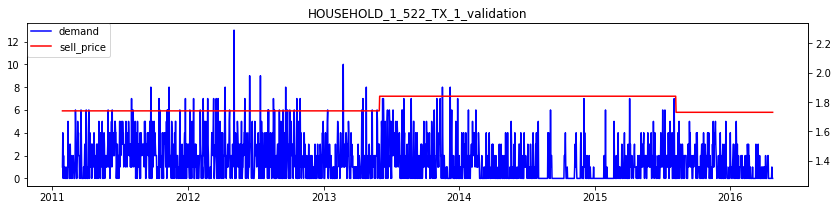

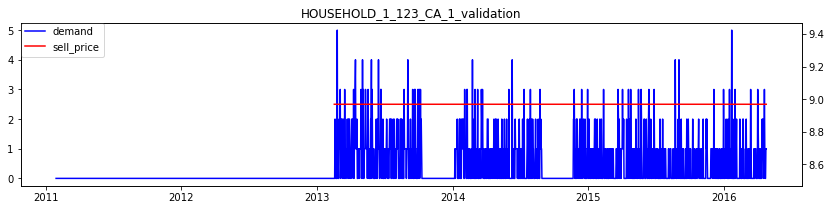

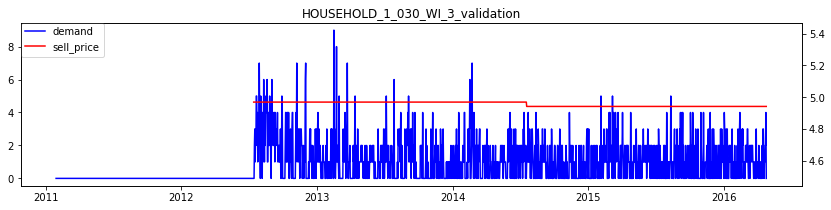

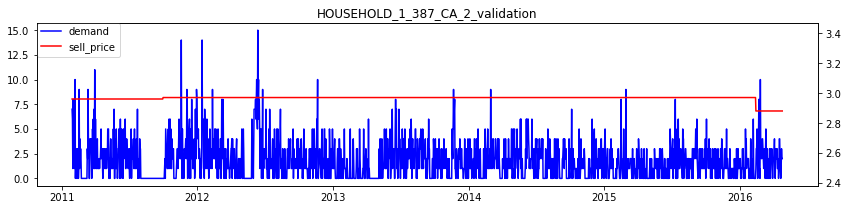

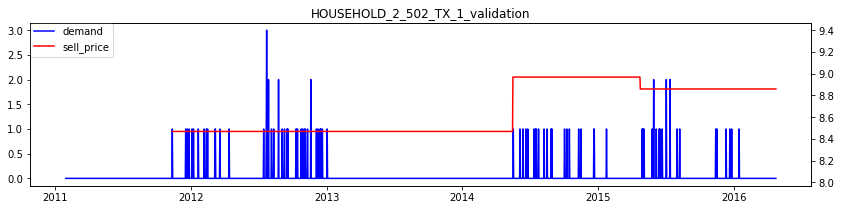

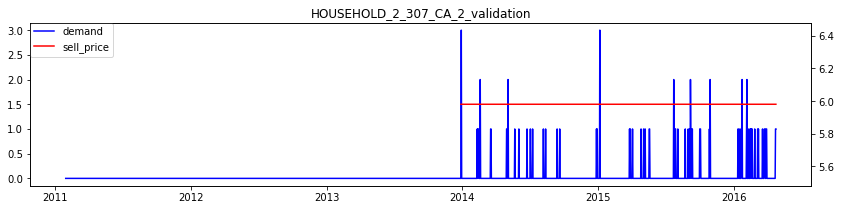

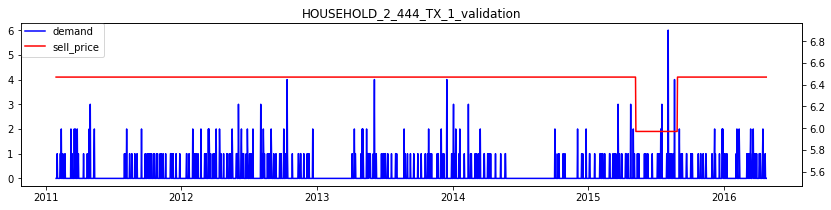

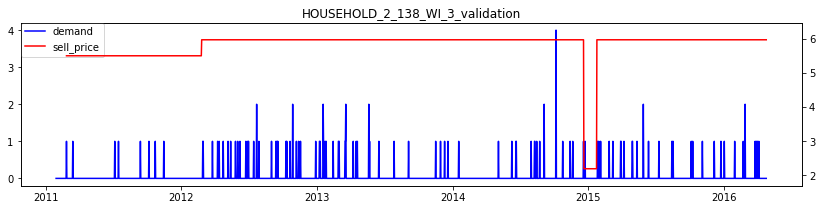

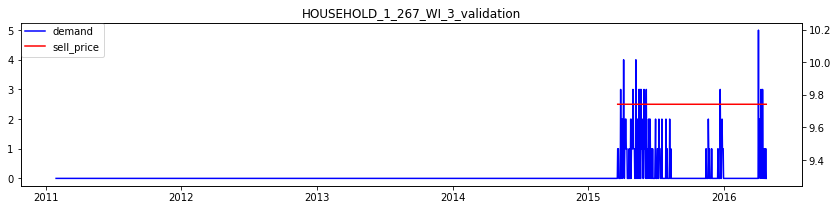

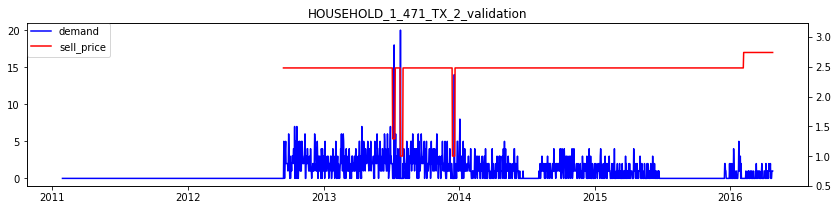

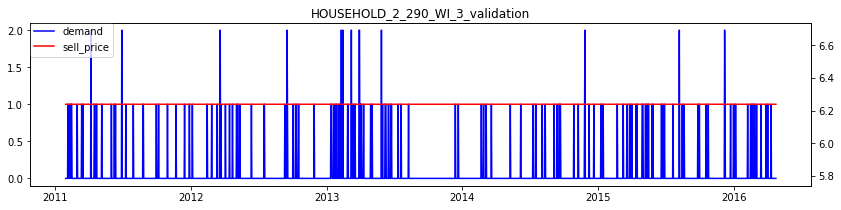

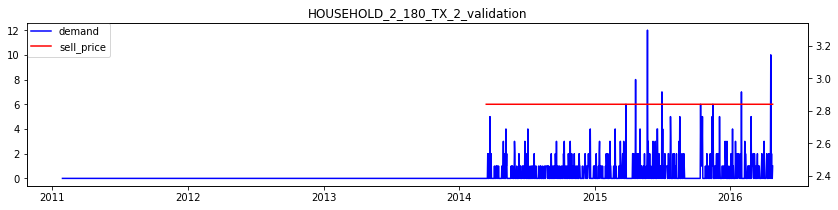

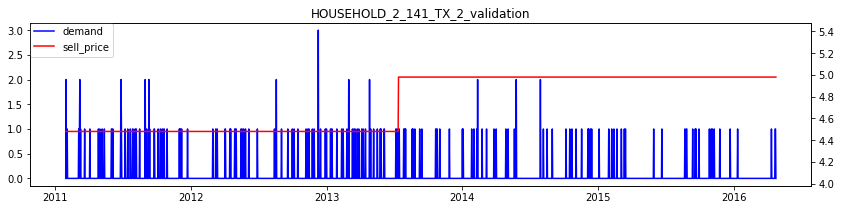

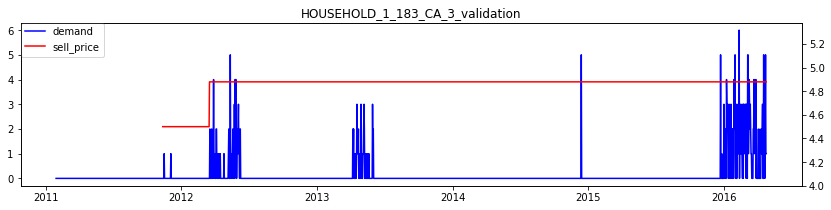

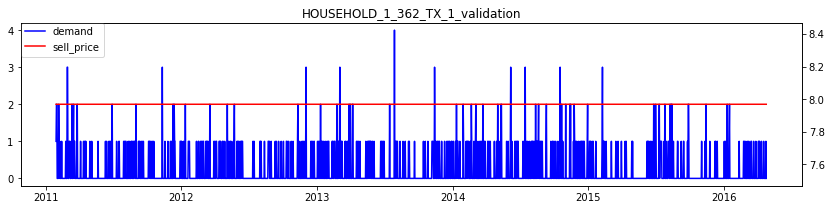

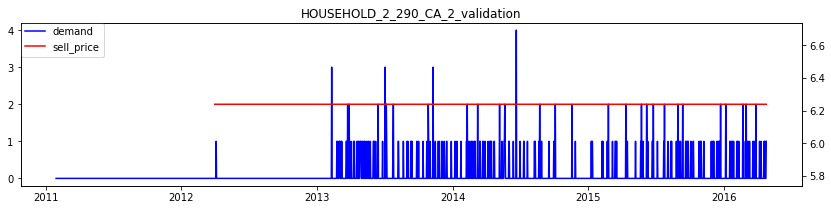

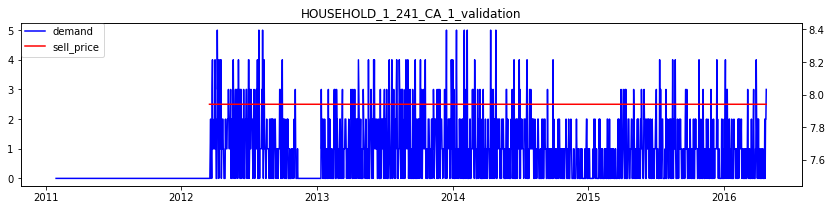

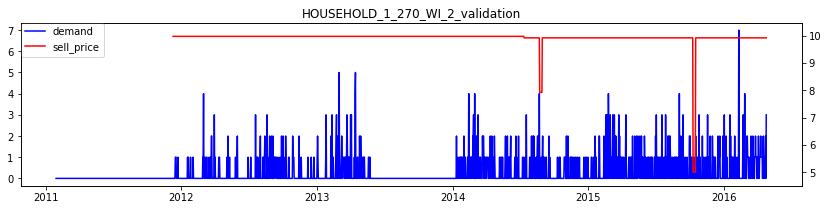

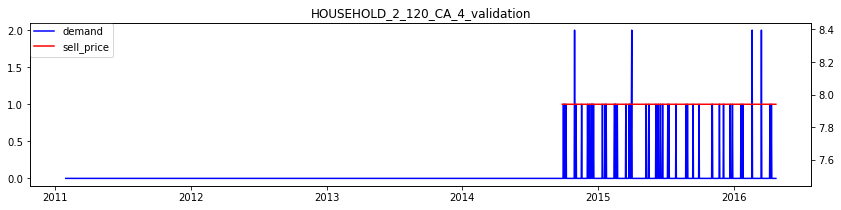

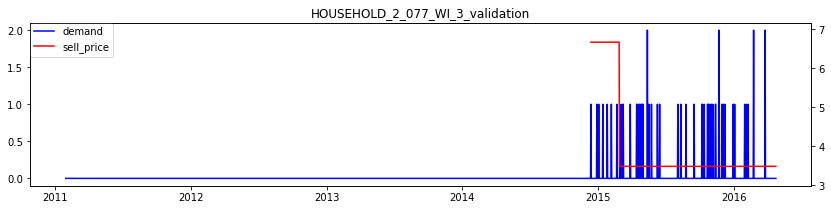

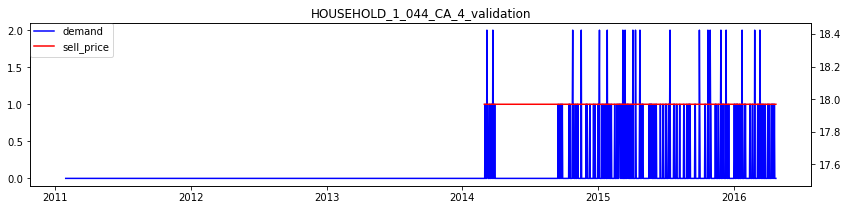

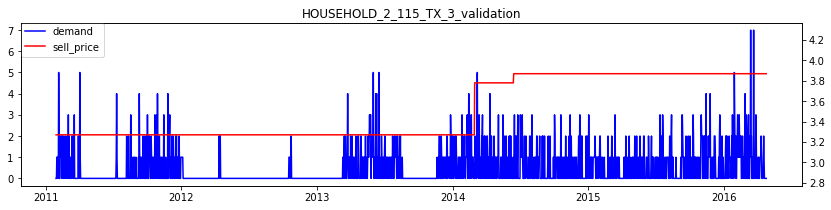

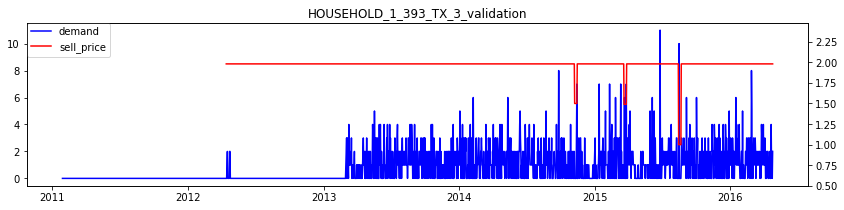

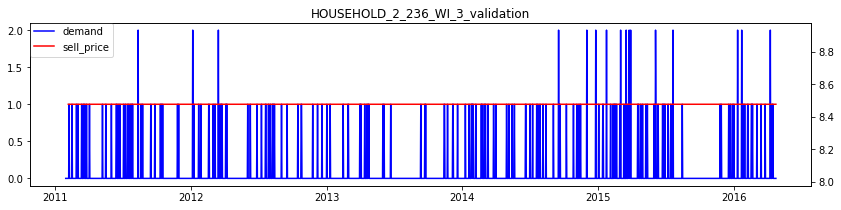

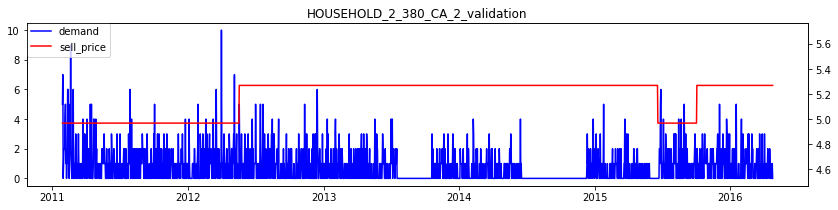

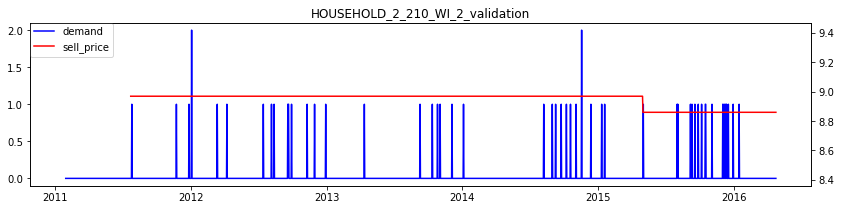

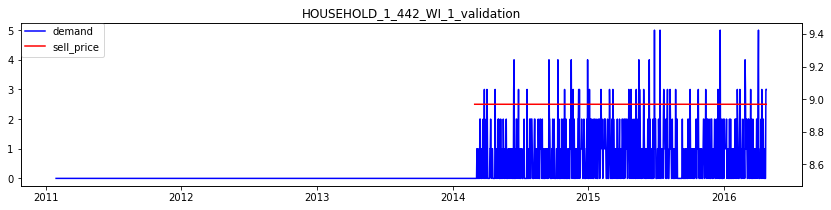

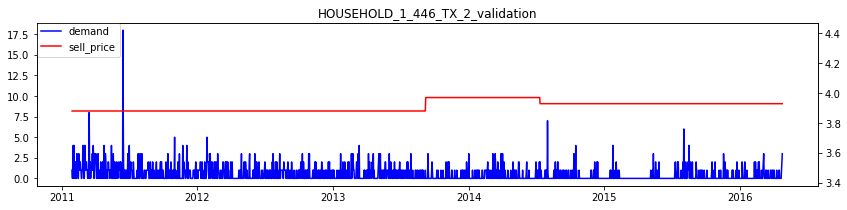

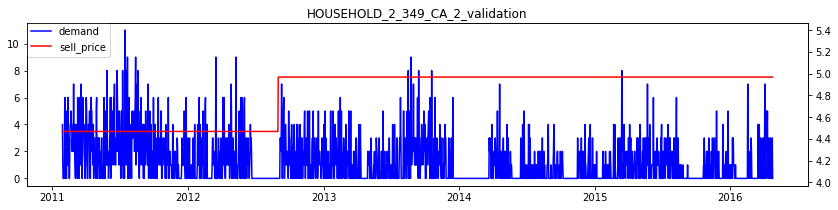

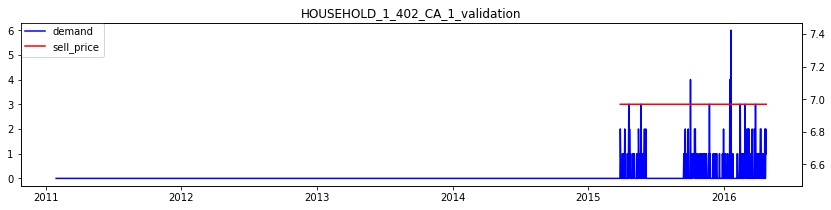

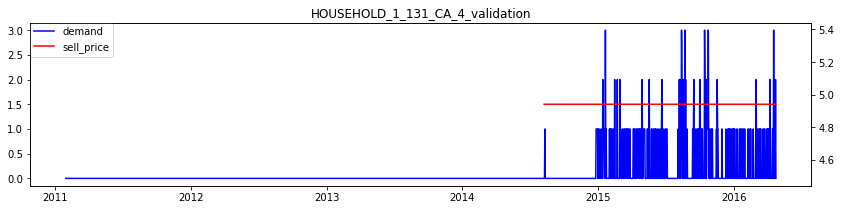

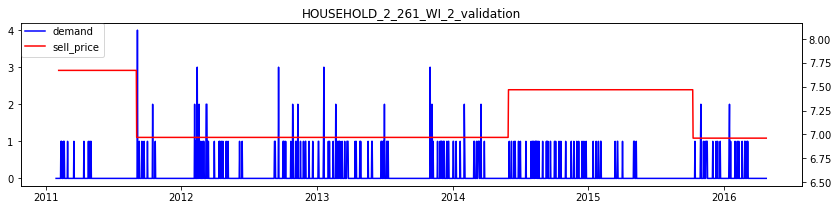

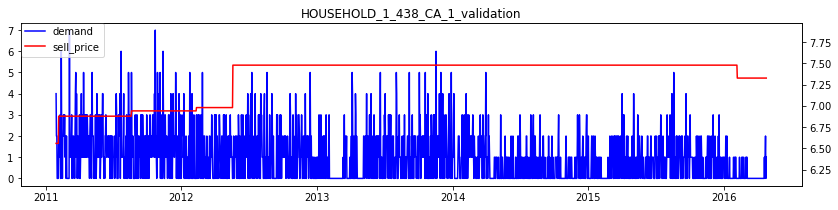

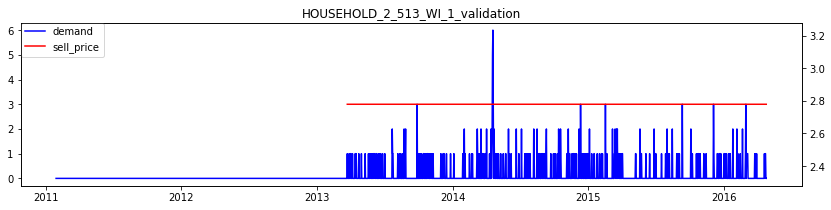

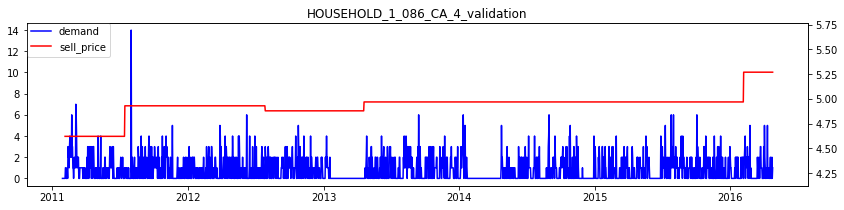

In [88]:
household_id = [id for id in ids if 'HOUSEHOLD' in id]
for i in range(len(household_id)):
    r = np.random.randint(1, len(household_id))
    plot(train, household_id[r])
    if i == 50:
        break

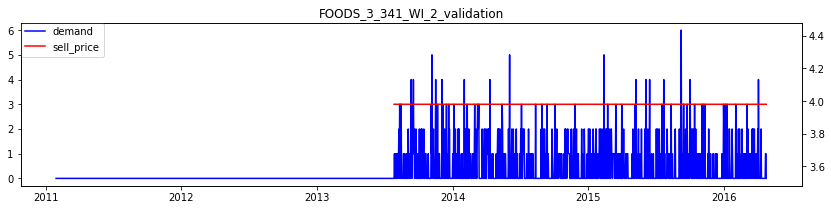

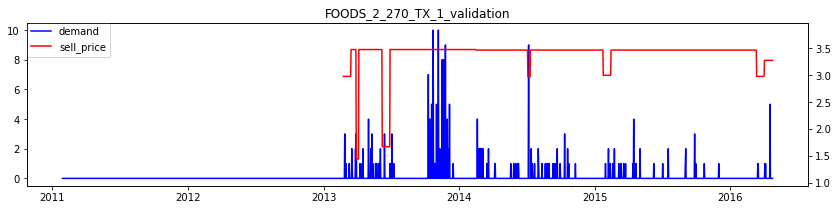

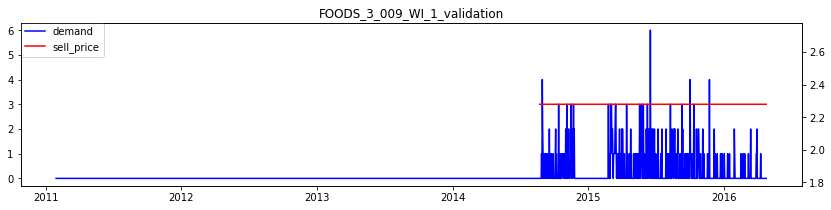

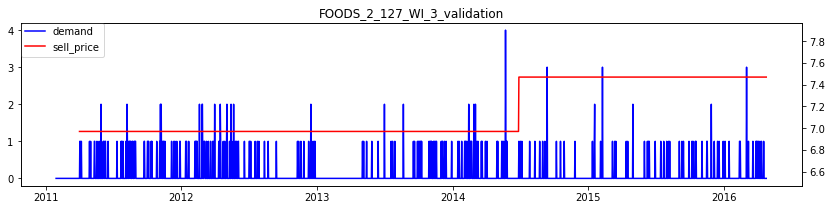

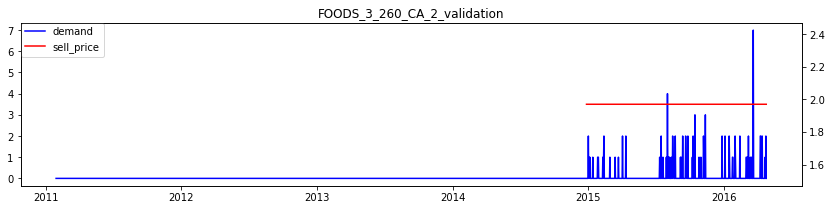

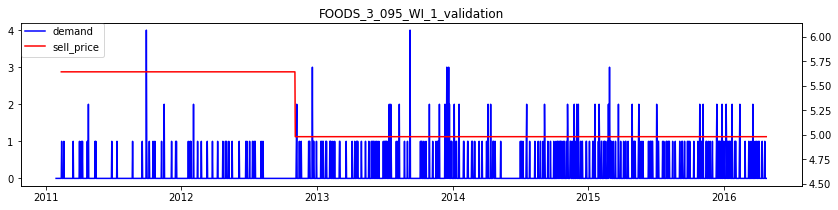

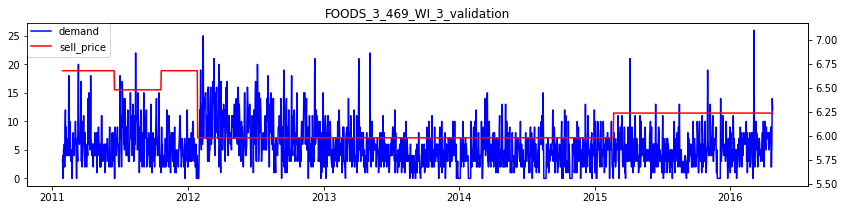

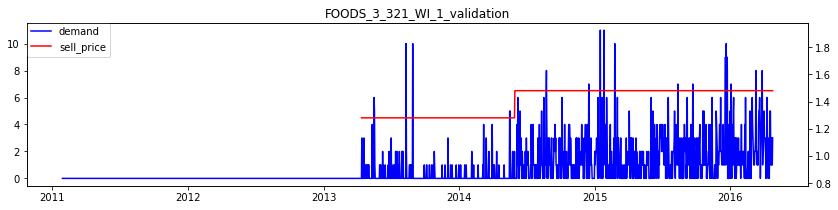

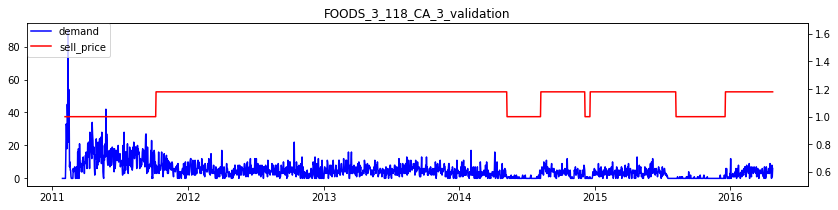

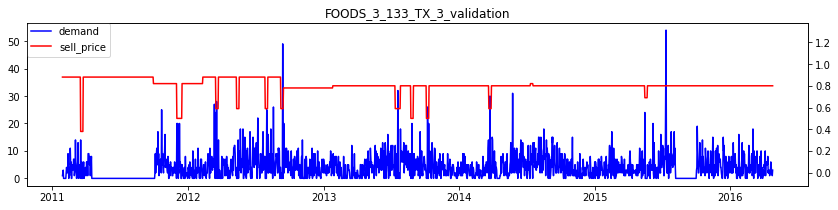

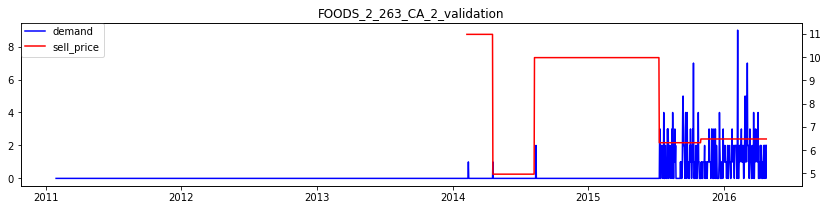

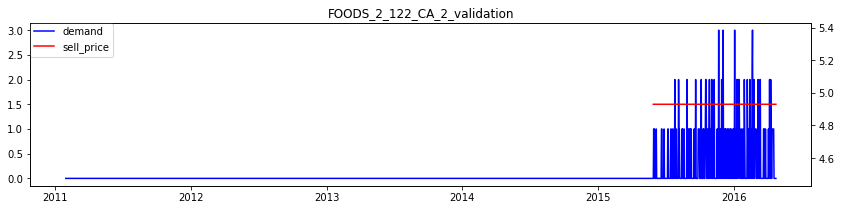

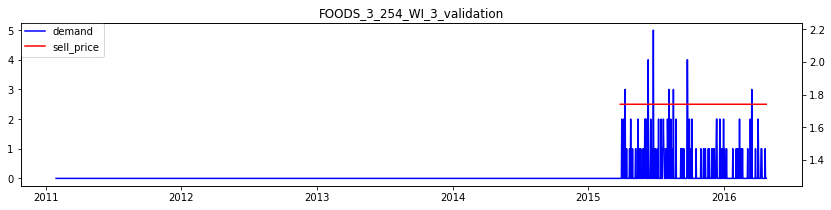

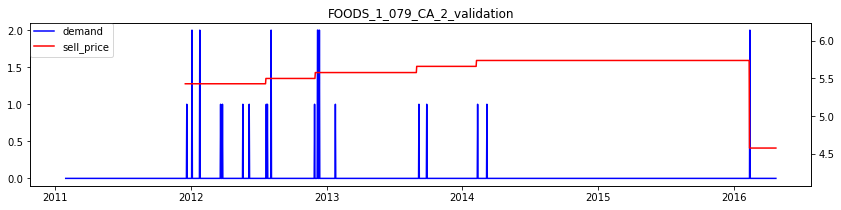

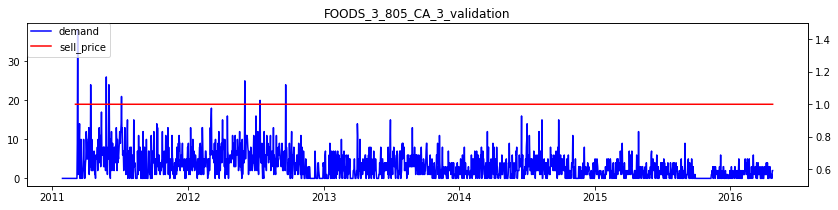

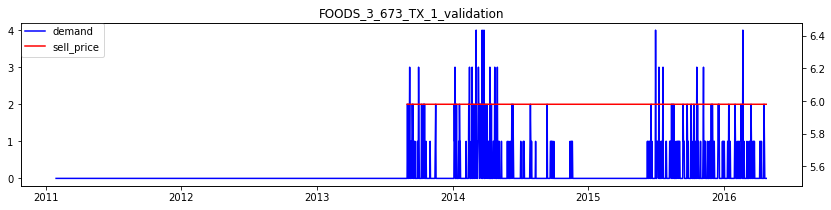

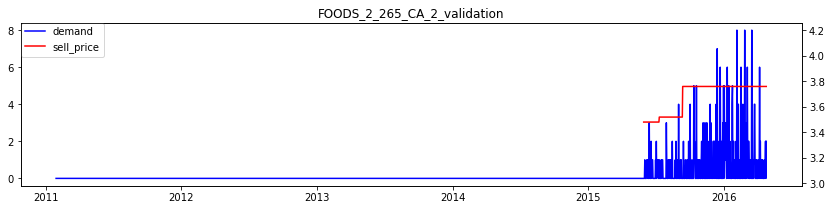

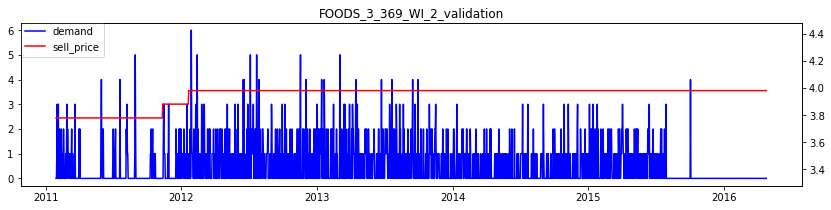

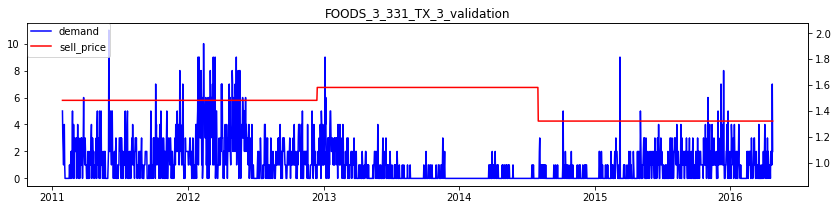

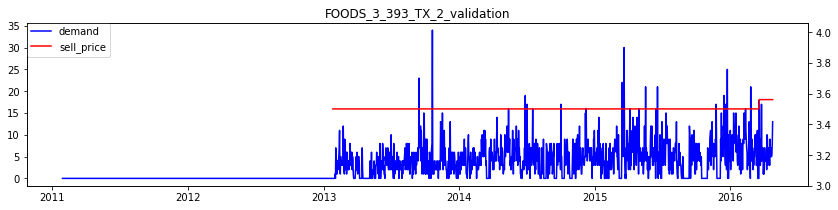

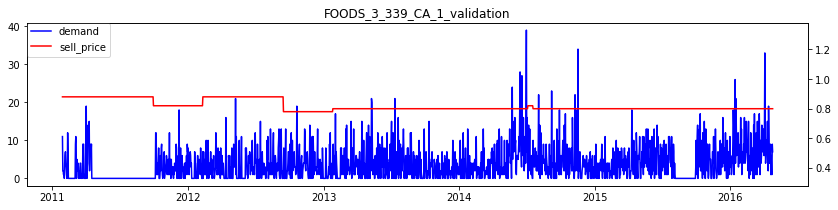

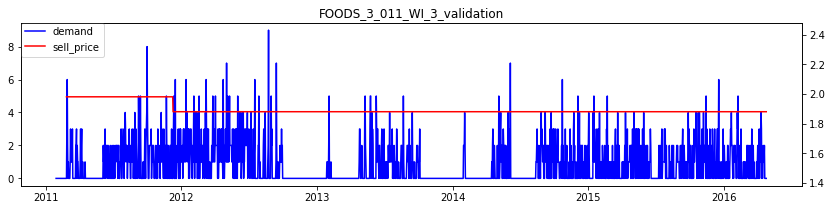

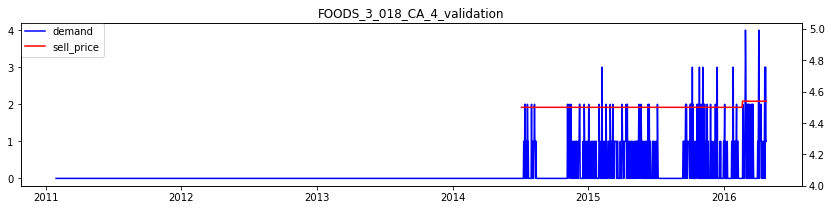

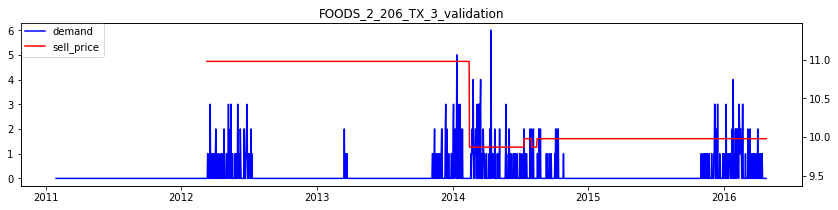

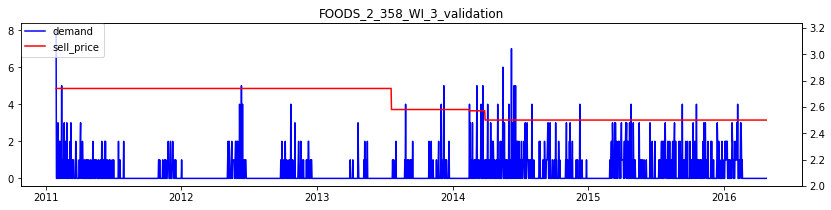

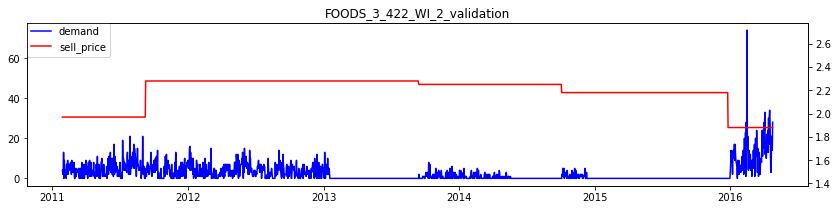

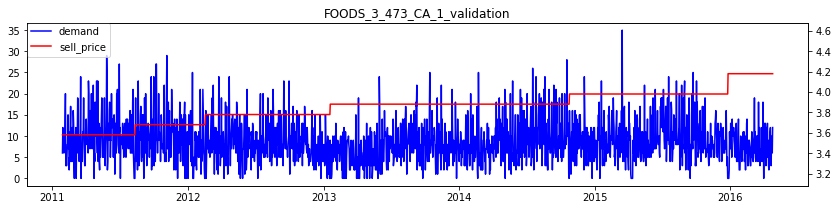

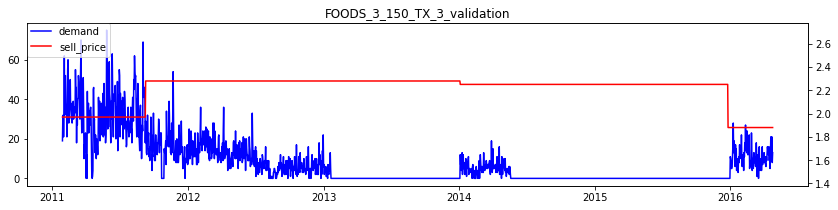

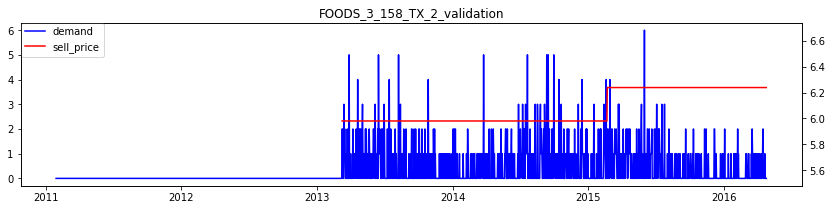

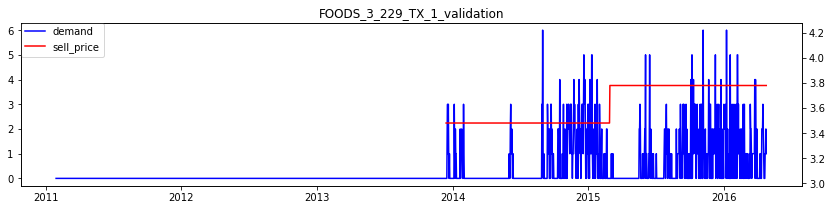

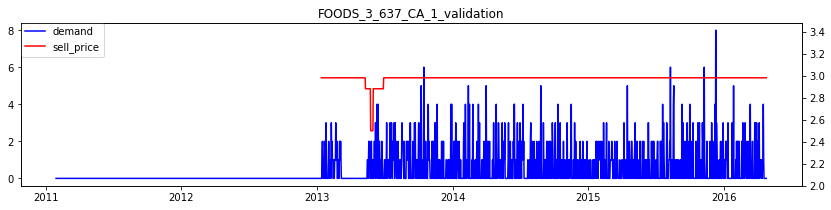

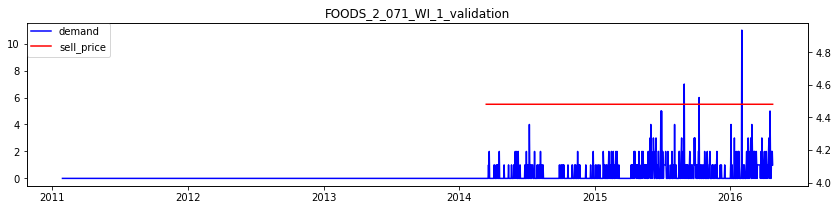

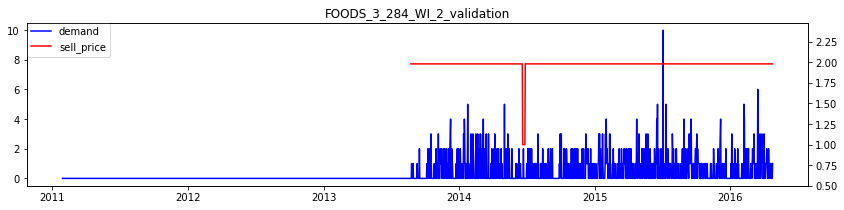

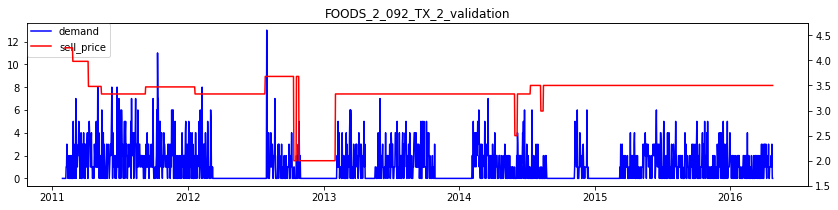

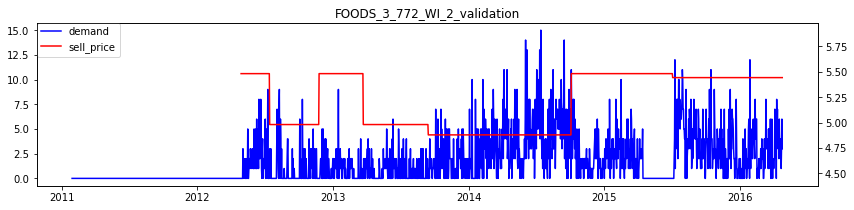

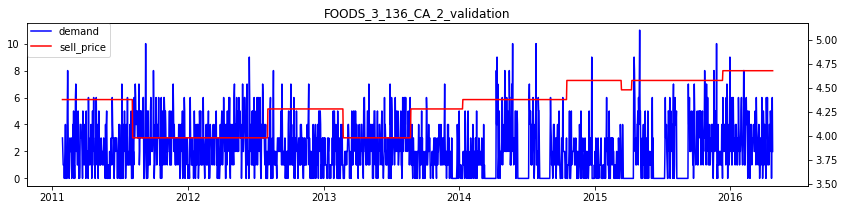

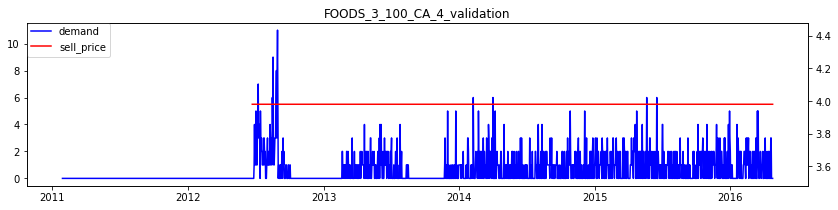

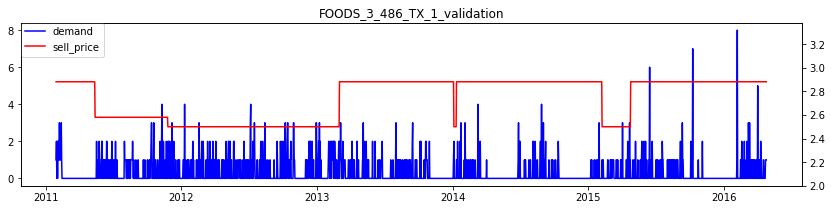

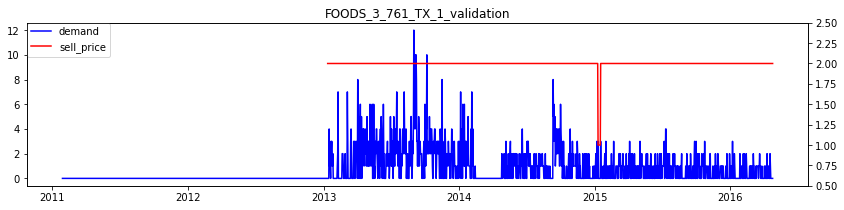

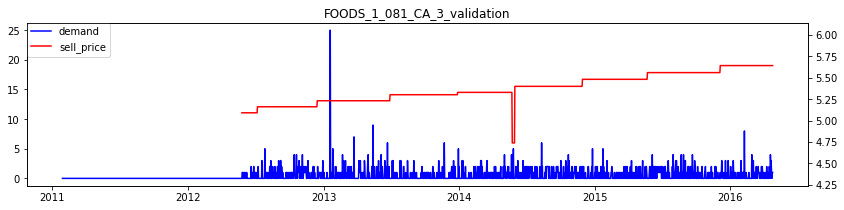

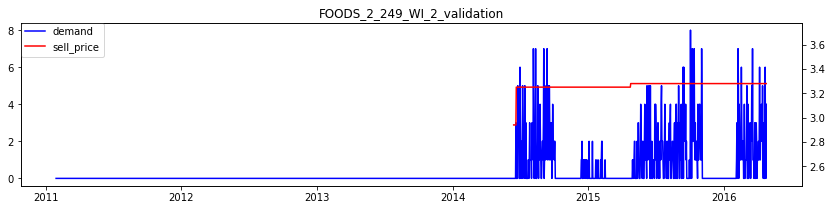

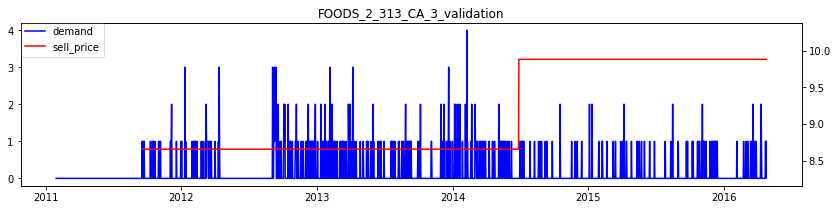

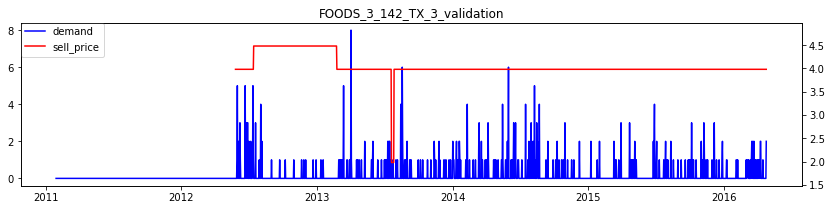

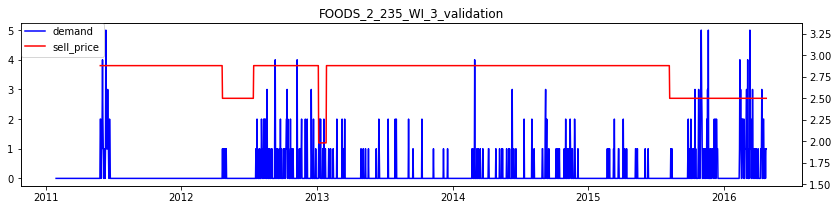

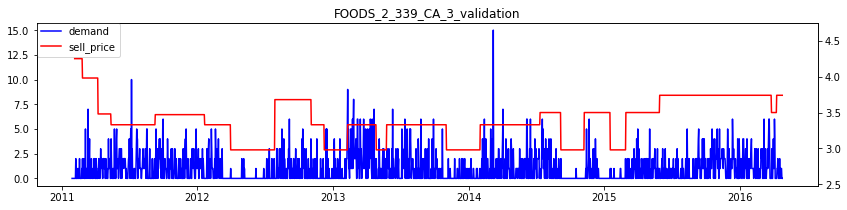

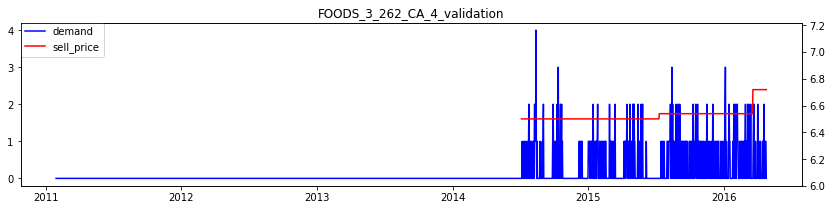

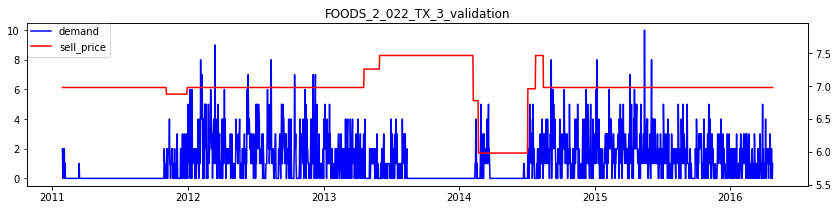

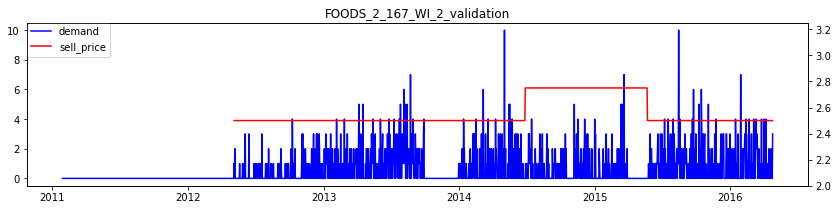

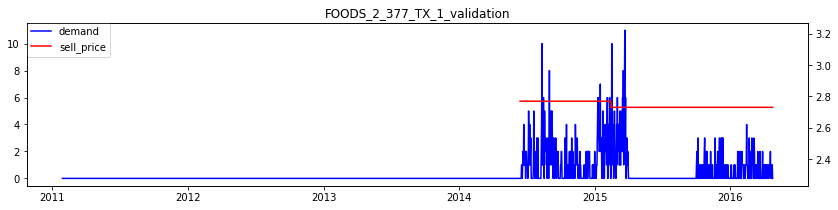

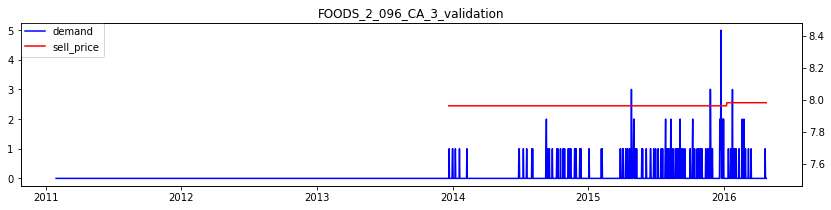

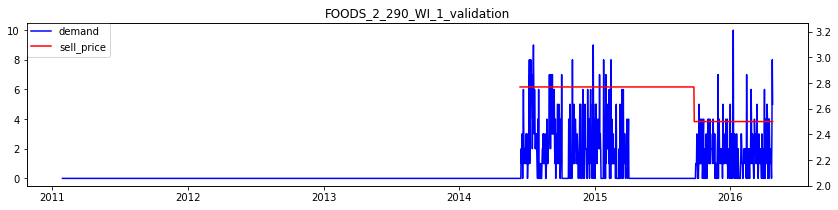

In [89]:
foods_id = [id for id in ids if 'FOODS' in id]
for i in range(len(foods_id)):
    r = np.random.randint(1, len(foods_id))
    plot(train, foods_id[r])
    if i == 50:
        break

---
Extermine Item

In [24]:
_df = train.dropna()[['id', 'date']]

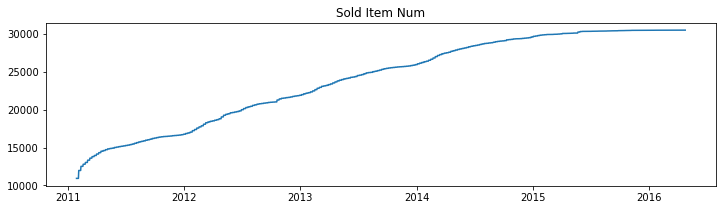

In [25]:
group = _df.groupby('date').count().reset_index()
fig = plt.figure(figsize=(12, 3), facecolor='w')
plt.plot(group['date'], group['id'])
plt.title('Sold Item Num')
plt.show()

In [90]:
# 販売開始しているのは店舗によって異なる
# 販売開始前の商品でも別店舗の売上データを活用できるかも
group = _df.groupby('id').count().reset_index()
group = group.sort_values(by=['date', 'id'], ascending=True)
print('Max of Date: ', group['date'].max())
group.head(10)

Max of Date:  1913


id  date
12070      FOODS_3_595_CA_1_validation    72
12072      FOODS_3_595_CA_3_validation    72
20218  HOUSEHOLD_1_020_WI_2_validation    72
22732  HOUSEHOLD_1_278_CA_3_validation    72
23061  HOUSEHOLD_1_311_CA_2_validation    72
23807  HOUSEHOLD_1_386_WI_1_validation    72
23923  HOUSEHOLD_1_400_CA_4_validation    72
23971  HOUSEHOLD_1_405_CA_2_validation    72
9083       FOODS_3_296_CA_4_validation    86
23928  HOUSEHOLD_1_400_WI_2_validation    86

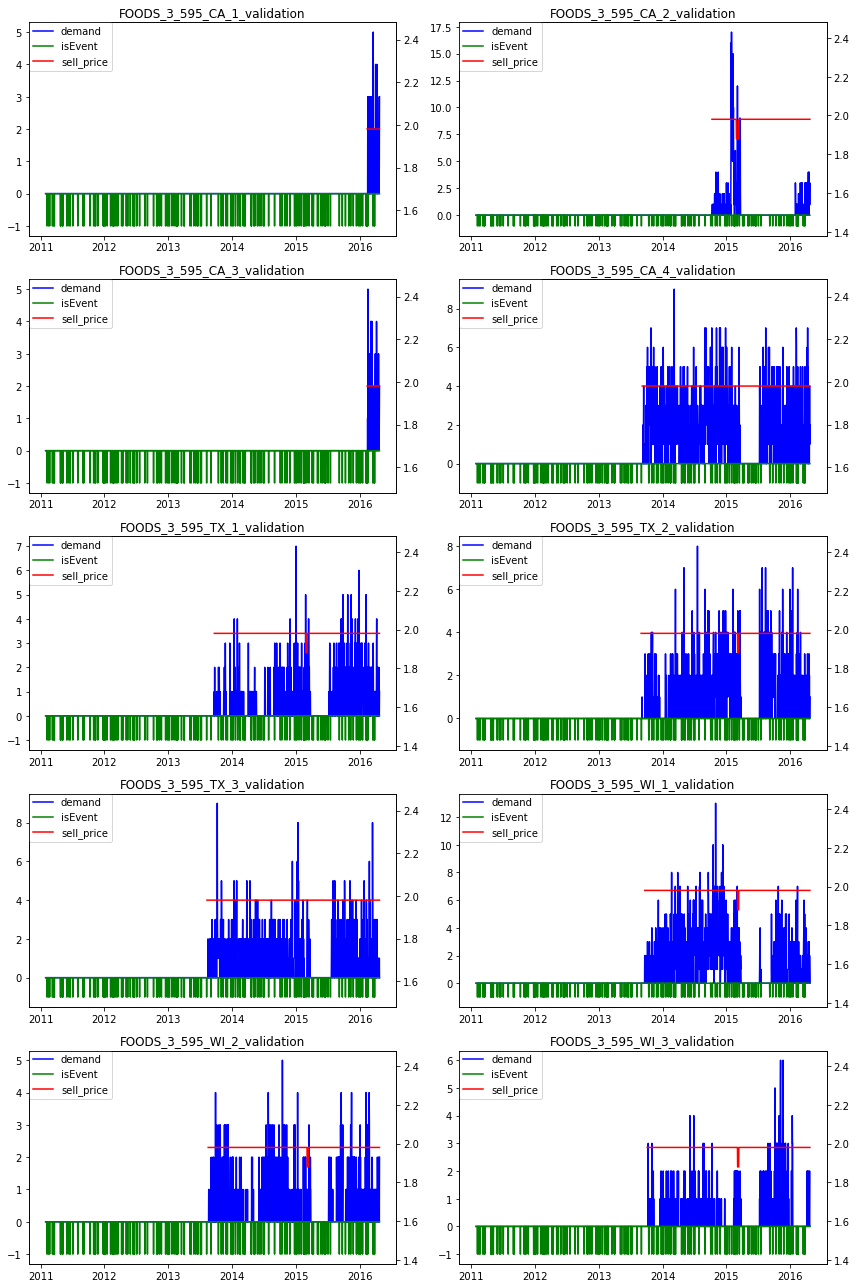

In [120]:
plot_per_item(train, 'FOODS_3_595')

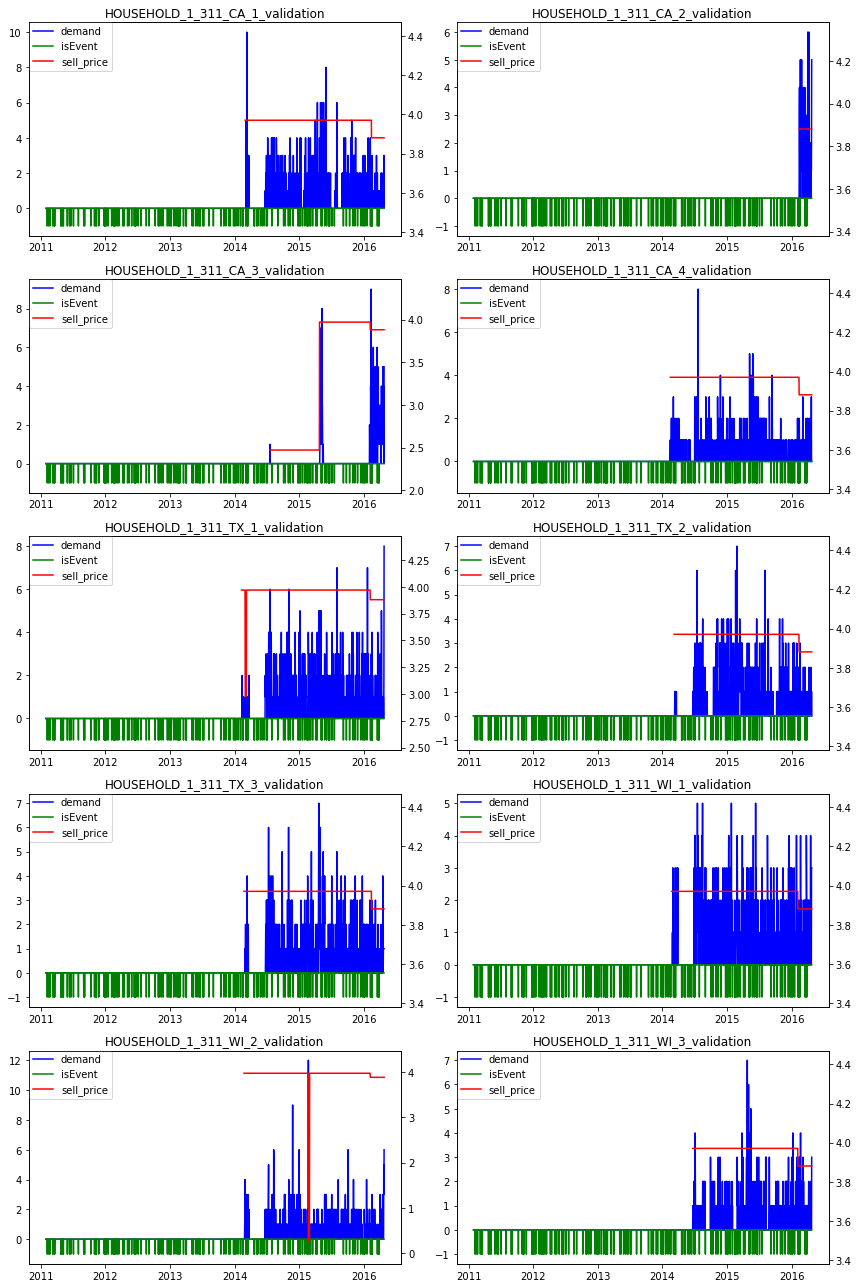

In [121]:
plot_per_item(train, 'HOUSEHOLD_1_311')

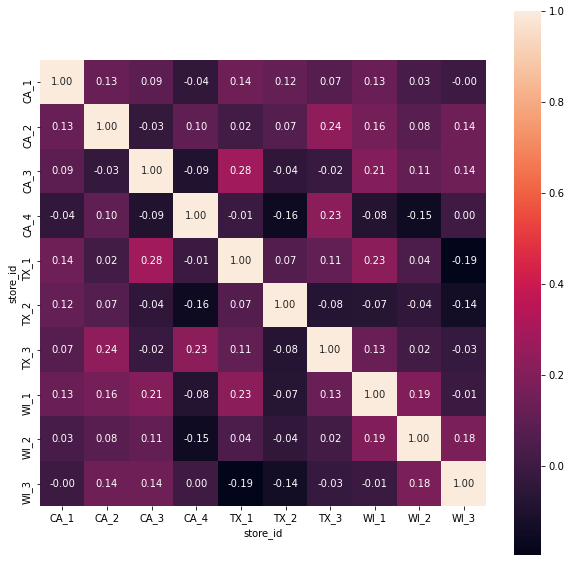

In [30]:
# ある特定のアイテムにおいて、店舗ごとの売上相関を見る
# 全然相関高くないのでそのまま当てはめられない
temp = train[train['item_id'] == 'HOUSEHOLD_1_020']
temp = temp.groupby(['store_id', 'date'])['demand'].mean().reset_index()
temp = pd.pivot(temp, index='date', columns='store_id', values='demand')

# temp = temp.replace(0, np.nan)
# temp.dropna(inplace=True, how='all')
temp = temp.iloc[-72:]
temp.shape

temp = temp.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(temp, annot=True, fmt='.2f', square=True)
plt.show()

---
item_id

In [124]:
temp = train.dropna()[['item_id', 'demand']]
temp = temp.groupby('item_id')['demand'].agg(['min', 'max', 'count', 'mean', 'median', 'std']).reset_index()
temp['item'] = temp['item_id'].apply(lambda x: x.split('_')[0])
temp.head()

item_id  min  max  count      mean  median       std   item
0  FOODS_1_001    0   24  19123  0.640433       0  1.319751  FOODS
1  FOODS_1_002    0    8  19123  0.383517       0  0.760427  FOODS
2  FOODS_1_003    0   22  19130  0.700157       0  1.257818  FOODS
3  FOODS_1_004    0  116  15140  8.552246       6  8.584537  FOODS
4  FOODS_1_005    0   30  19109  1.199121       0  2.248477  FOODS

---
標準偏差ごとに波形を見てみる

In [125]:
# 標準偏差
_temp = temp.sort_values(by='std', ascending=False)
_temp.head(10)

item_id  min  max  count       mean  median        std   item
702   FOODS_3_090    0  763  19130  52.406116      38  61.204986  FOODS
1198  FOODS_3_586    0  237  19130  48.104652      42  32.892232  FOODS
732   FOODS_3_120    0  276  14909  18.988799       9  26.658199  FOODS
864   FOODS_3_252    0  184  19130  29.550392      25  22.218959  FOODS
930   FOODS_3_318    0  436  19130  13.622478       8  20.976239  FOODS
846   FOODS_3_234    0  323  19067  13.172497       6  20.712806  FOODS
1153  FOODS_3_541    0  306  19130  14.251124       8  19.792923  FOODS
1247  FOODS_3_635    0  355  19060  14.802413       8  19.787082  FOODS
1417  FOODS_3_808    0  329  19067  14.783605       9  19.368463  FOODS
1199  FOODS_3_587    0  154  19130  20.706691      18  18.701665  FOODS

In [126]:
_temp = temp.sort_values(by='std', ascending=True)
_temp.head(10)

item_id  min  max  count      mean  median       std       item
1971    HOBBIES_2_119    0    4  18052  0.036561       0  0.193500    HOBBIES
2924  HOUSEHOLD_2_392    0    3  16722  0.053522       0  0.240494  HOUSEHOLD
2620  HOUSEHOLD_2_087    0    4  18787  0.055730       0  0.245545  HOUSEHOLD
2575  HOUSEHOLD_2_042    0    3  19081  0.056601       0  0.249829  HOUSEHOLD
2680  HOUSEHOLD_2_147    0    3  18899  0.061114       0  0.254124  HOUSEHOLD
1642    HOBBIES_1_212    0    3  16162  0.058347       0  0.254406    HOBBIES
2606  HOUSEHOLD_2_073    0    4  15371  0.059918       0  0.254538  HOUSEHOLD
2551  HOUSEHOLD_2_018    0    4  19011  0.061017       0  0.256962  HOUSEHOLD
1488    HOBBIES_1_052    0    5  14979  0.059684       0  0.258988    HOBBIES
2619  HOUSEHOLD_2_086    0    6  15315  0.062618       0  0.264941  HOUSEHOLD

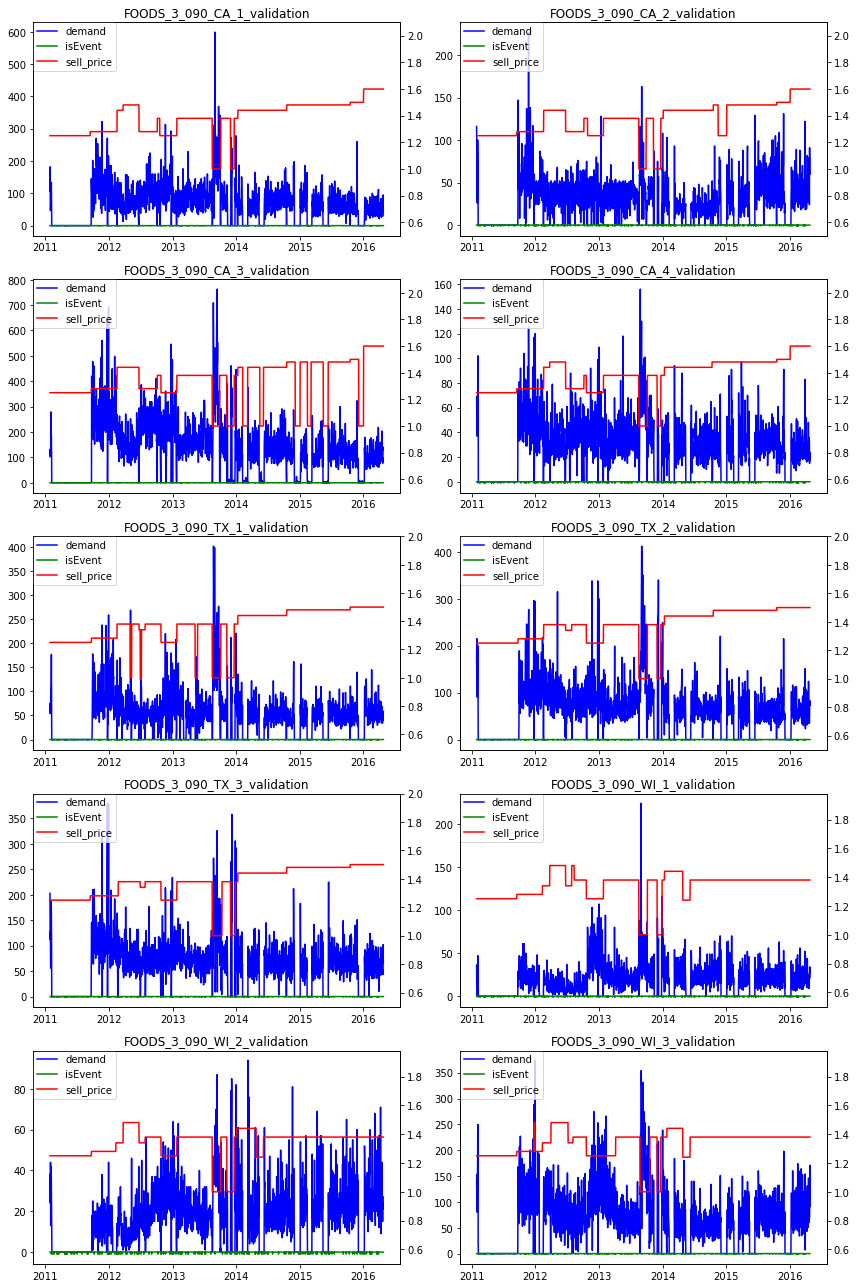

In [122]:
# 標準偏差が大きい例
plot_per_item(train, 'FOODS_3_090')

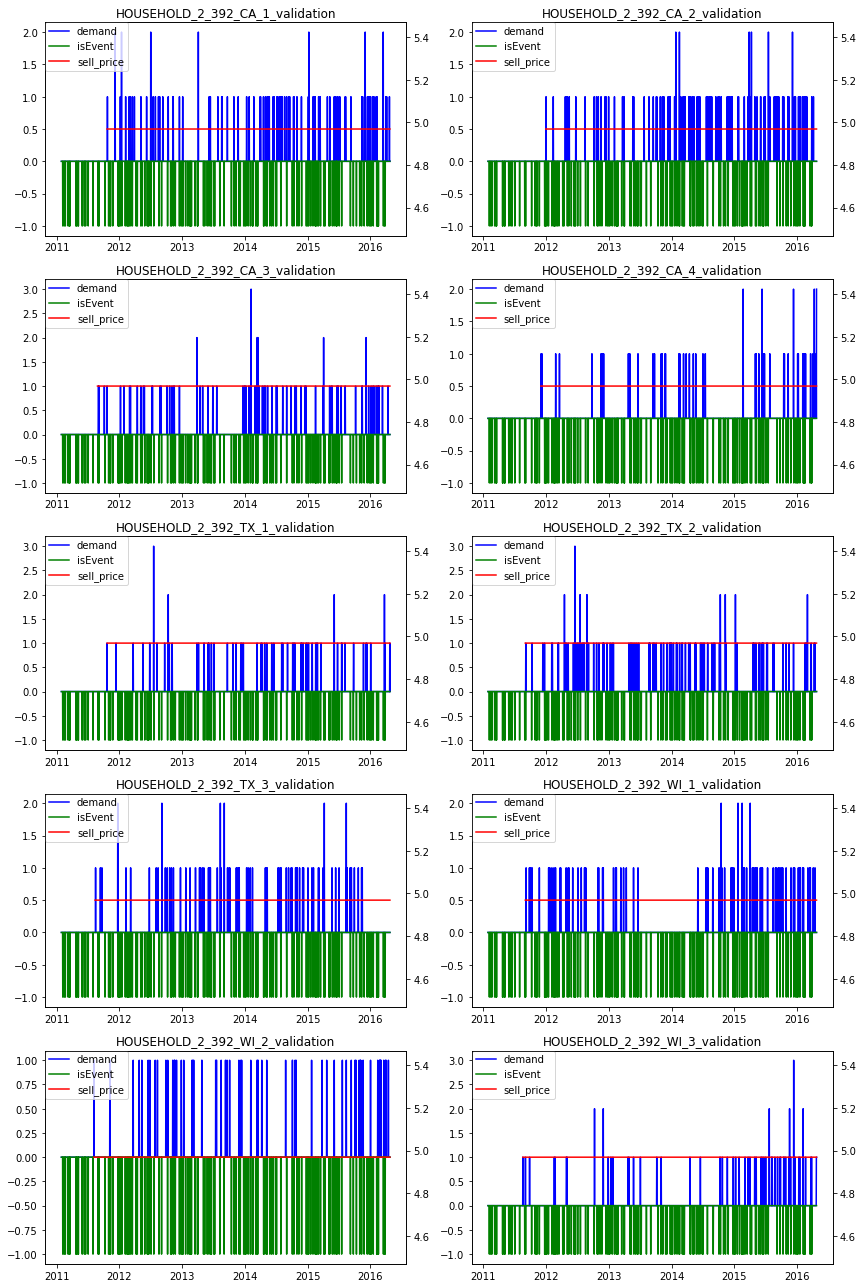

In [123]:
# 標準偏差が小さい例
plot_per_item(train, 'HOUSEHOLD_2_392')

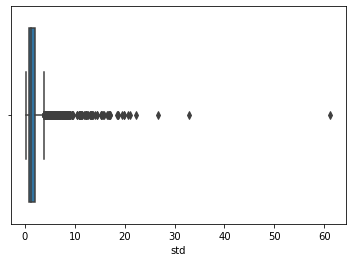

In [130]:
sns.boxplot(temp['std'])
plt.show()

In [135]:
# 標準偏差が平均くらいのもの
_temp = temp[temp['std'] < temp['std'].mean()]
_temp = _temp.sort_values(by='std', ascending=False)
_temp.head()

item_id  min  max  count      mean  median       std       item
1121      FOODS_3_509    0   22  12851  1.455607       1  1.864838      FOODS
130       FOODS_1_133    0   87  18969  0.651062       0  1.864016      FOODS
491       FOODS_2_277    0   56   6915  0.785539       0  1.862769      FOODS
2403  HOUSEHOLD_1_411    0   16  18577  1.765786       1  1.862464  HOUSEHOLD
647       FOODS_3_034    0   41   9764  1.786051       1  1.862091      FOODS

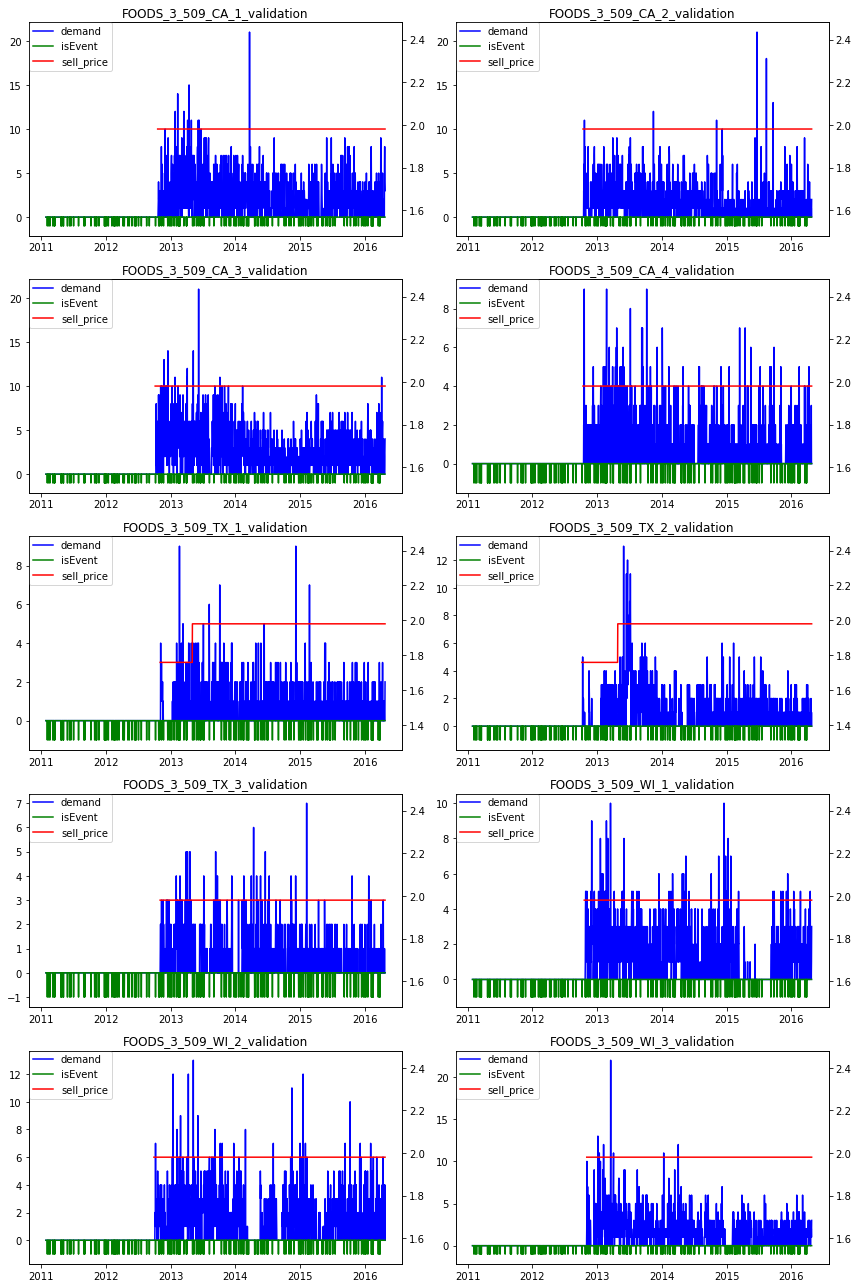

In [136]:
# 標準偏差が平均くらいの例
plot_per_item(train, 'FOODS_3_509')

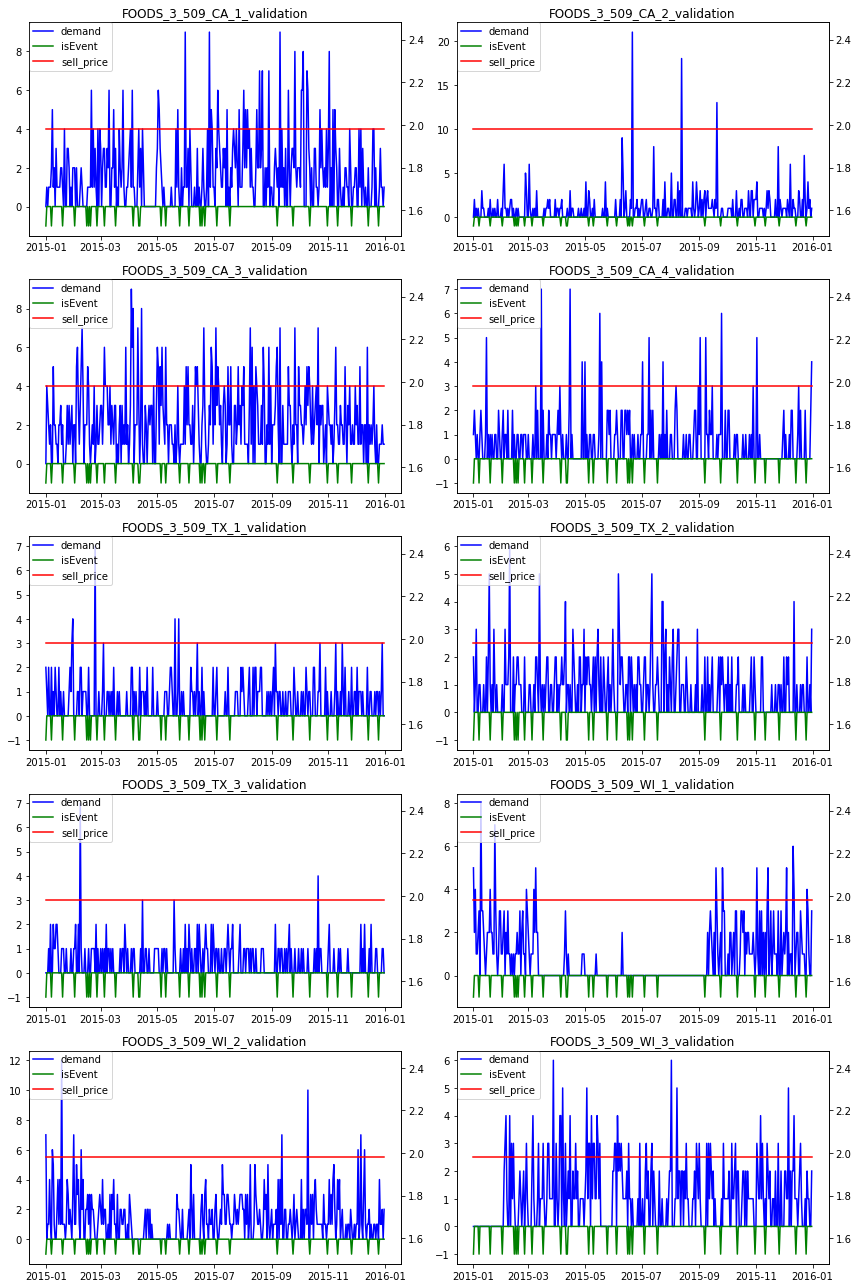

In [137]:
# 標準偏差が平均くらいの例
plot_per_item(train[train['year'] == 2015], 'FOODS_3_509')

---
### Correlation per dept_id

In [142]:
# ある特定の店に絞って全商品の購買数の相関を見てみる
temp = train[(train['store_id'] == 'CA_1') & (train['cat_id'] == 'FOODS')]
temp = pd.pivot(temp, index='date', columns='item_id', values='demand')
temp = temp.corr()
temp.head()

item_id      FOODS_1_001  FOODS_1_002  FOODS_1_003  FOODS_1_004  FOODS_1_005  \
item_id                                                                        
FOODS_1_001     1.000000     0.078043     0.042245     0.013629     0.029628   
FOODS_1_002     0.078043     1.000000     0.032650    -0.080548     0.043066   
FOODS_1_003     0.042245     0.032650     1.000000     0.009114     0.015433   
FOODS_1_004     0.013629    -0.080548     0.009114     1.000000    -0.133658   
FOODS_1_005     0.029628     0.043066     0.015433    -0.133658     1.000000   

item_id      FOODS_1_006  FOODS_1_008  FOODS_1_009  FOODS_1_010  FOODS_1_011  \
item_id                                                                        
FOODS_1_001     0.003328    -0.024846     0.082720     0.009057     0.028021   
FOODS_1_002     0.019094    -0.018867    -0.021300    -0.037245     0.010727   
FOODS_1_003     0.029167     0.038179    -0.001715    -0.044034     0.020456   
FOODS_1_004    -0.031296     0.067940     0.091623     0.050862     0.083568   
FOODS_1_005     0.035643     0.070209     0.068064    -0.037996     0.017281   

item_id      FOODS_1_012  FOODS_1_013  FOODS_1_014  FOODS_1_015  FOODS_1_016  \
item_id                                                                        
FOODS_1_001    -0.015227     0.024238    -0.055970     0.071806    -0.006902   
FOODS_1_002    -0.144983     0.040234    -0.095545    -0.005739     0.028892   
FOODS_1_003     0.009299     0.006038    -0.018787     0.001357     0.068097   
FOODS_1_004     0.244283     0.005948     0.113970     0.006425     0.072689   
FOODS_1_005    -0.029487     0.027858    -0.027206     0.079522     0.020964   

item_id      FOODS_1_017  FOODS_1_018  FOODS_1_019  FOODS_1_020  FOODS_1_021  \
item_id                                                                        
FOODS_1_001     0.005795     0.018395     0.100190     0.062819    -0.062673   
FOODS_1_002    -0.012238    -0.051852     0.095000    -0.009353    -0.087734   
FOODS_1_003     0.001086     0.075489     0.085115    -0.000613    -0.033727   
FOODS_1_004     0.088809     0.221408    -0.212182     0.095793     0.265564   
FOODS_1_005    -0.015581    -0.039874     0.134440     0.052853    -0.101163   

item_id      FOODS_1_022  FOODS_1_023  FOODS_1_024  FOODS_1_025  FOODS_1_026  \
item_id                                                                        
FOODS_1_001    -0.033269     0.030746     0.055655    -0.042748    -0.004008   
FOODS_1_002    -0.021813    -0.097470     0.003252    -0.129864     0.005980   
FOODS_1_003    -0.018642     0.023397     0.010478    -0.012317     0.030690   
FOODS_1_004     0.081516     0.160555    -0.039794     0.157289     0.128261   
FOODS_1_005    -0.026232     0.003562     0.017772    -0.056368     0.032308   

item_id      FOODS_1_027  FOODS_1_028  FOODS_1_029  FOODS_1_030  FOODS_1_031  \
item_id                                                                        
FOODS_1_001    -0.020118    -0.056123     0.075141     0.020835     0.002433   
FOODS_1_002    -0.125984    -0.111394     0.080494     0.022486     0.021019   
FOODS_1_003    -0.007449    -0.028962    -0.018368     0.001318    -0.006787   
FOODS_1_004     0.263542     0.268258    -0.057430     0.038857     0.052143   
FOODS_1_005    -0.102669    -0.140447     0.038645     0.073004     0.075840   

item_id      FOODS_1_032  FOODS_1_033  FOODS_1_034  FOODS_1_035  FOODS_1_036  \
item_id                                                                        
FOODS_1_001     0.108919    -0.029608    -0.060354     0.008497     0.057977   
FOODS_1_002     0.045526    -0.034412     0.024612     0.013442    -0.011007   
FOODS_1_003     0.070767    -0.003863     0.028065     0.011727     0.016598   
FOODS_1_004    -0.023794     0.010340     0.030614     0.050470     0.134384   
FOODS_1_005     0.084776     0.024175    -0.033365    -0.003980     0.064793   

item_id      FOODS_1_037  FOODS_1_038  FOODS_1_039  FOODS_1_040  FOODS_1_

In [158]:
_temp = pd.DataFrame(temp.loc['FOODS_1_043', :])
_temp

FOODS_1_043
item_id                 
FOODS_1_001     0.036182
FOODS_1_002    -0.054271
FOODS_1_003     0.007710
FOODS_1_004     0.719465
FOODS_1_005    -0.135473
FOODS_1_006    -0.033899
FOODS_1_008     0.036552
FOODS_1_009     0.123384
FOODS_1_010     0.034485
FOODS_1_011     0.090756
FOODS_1_012     0.244102
FOODS_1_013    -0.012889
FOODS_1_014     0.125751
FOODS_1_015     0.010311
FOODS_1_016     0.092618
FOODS_1_017     0.064985
FOODS_1_018     0.228401
FOODS_1_019    -0.132041
FOODS_1_020     0.111552
FOODS_1_021     0.217816
FOODS_1_022     0.064672
FOODS_1_023     0.148408
FOODS_1_024    -0.018846
FOODS_1_025     0.152523
FOODS_1_026     0.077997
FOODS_1_027     0.273216
FOODS_1_028     0.260082
FOODS_1_029    -0.055774
FOODS_1_030     0.056996
FOODS_1_031     0.051434
FOODS_1_032    -0.013635
FOODS_1_033     0.006884
FOODS_1_034     0.039043
FOODS_1_035     0.017710
FOODS_1_036     0.128404
FOODS_1_037     0.090547
FOODS_1_038    -0.045303
FOODS_1_039     0.108189
FOODS_1_040     0.174660
FOODS_1_041     0.051723
FOODS_1_042     0.073016
FOODS_1_043     1.000000
FOODS_1_044    -0.054640
FOODS_1_045     0.174791
FOODS_1_046     0.235445
FOODS_1_047    -0.125571
FOODS_1_048     0.095416
FOODS_1_049     0.037893
FOODS_1_050     0.076593
FOODS_1_051     0.086886
FOODS_1_052     0.137731
FOODS_1_053    -0.000177
FOODS_1_054     0.060002
FOODS_1_055    -0.020178
FOODS_1_056     0.088539
FOODS_1_057     0.088325
FOODS_1_058     0.580233
FOODS_1_059     0.052412
FOODS_1_060     0.042955
FOODS_1_061     0.129576
FOODS_1_062     0.014853
FOODS_1_063    -0.007704
FOODS_1_064     0.043512
FOODS_1_065     0.030938
FOODS_1_066    -0.006381
FOODS_1_067    -0.014773
FOODS_1_068     0.170267
FOODS_1_069     0.010850
FOODS_1_070     0.100191
FOODS_1_071     0.075229
FOODS_1_072     0.164279
FOODS_1_073    -0.038046
FOODS_1_074     0.072619
FOODS_1_075    -0.074090
FOODS_1_076     0.021100
FOODS_1_077     0.126105
FOODS_1_078     0.168206
FOODS_1_079     0.084955
FOODS_1_080     0.017890
FOODS_1_081     0.102861
FOODS_1_082     0.096107
FOODS_1_083     0.059244
FOODS_1_084     0.069946
FOODS_1_085     0.086201
FOODS_1_086     0.162643
FOODS_1_087     0.095583
FOODS_1_088    -0.029710
FOODS_1_089     0.091608
FOODS_1_090    -0.048370
FOODS_1_091     0.049538
FOODS_1_092     0.252175
FOODS_1_093     0.054095
FOODS_1_094    -0.086710
FOODS_1_095    -0.021348
FOODS_1_096    -0.008429
FOODS_1_097     0.097961
FOODS_1_098    -0.010714
FOODS_1_099     0.273484
FOODS_1_101    -0.011183
FOODS_1_102     0.114000
FOODS_1_103    -0.123319
FOODS_1_104    -0.036572
FOODS_1_105     0.132506
FOODS_1_106    -0.070337
FOODS_1_107     0.043089
FOODS_1_108    -0.016900
FOODS_1_109     0.113710
FOODS_1_110     0.621506
FOODS_1_111    -0.011011
FOODS_1_112    -0.021438
FOODS_1_113     0.192417
FOODS_1_114    -0.089941
FOODS_1_115     0.221055
FOODS_1_116     0.034652
FOODS_1_117     0.013166
FOODS_1_118     0.046287
FOODS_1_119    -0.038941
FOODS_1_120     0.458839
FOODS_1_121    -0.098711
FOODS_1_122     0.075557
FOODS_1_123    -0.062579
FOODS_1_124     0.055328
FOODS_1_125     0.117170
FOODS_1_126     0.087191
FOODS_1_127    -0.021874
FOODS_1_128     0.003785
FOODS_1_129     0.000533
FOODS_1_130     0.140244
FOODS_1_131     0.056318
FOODS_1_132     0.260344
FOODS_1_133    -0.048345
FOODS_1_134     0.181240
FOODS_1_135    -0.043528
FOODS_1_136    -0.017798
FOODS_1_137     0.127943
FOODS_1_138     0.048245
FOODS_1_139     0.174883
FOODS_1_140     0.021178
FOODS_1_141    -0.013775
FOODS_1_142    -0.038748
FOODS_1_143    -0.012530
FOODS_1_144     0.089790
FOODS_1_145     0.149432
FOODS_1_146     0.061215
FOODS_1_147     0.016364
FOODS_1_148     0.098889
FOODS_1_149     0.102515
FOODS_1_150     0.028042
FOODS_1_151     0.080807
FOODS_1_152     0.024516
FOODS_1_153     0.118468
FOODS_1_154     0.041856
FOODS_1_155     0.111566
FOODS_1_156     0.077617
FOODS_1_157     0.006687
FOODS_1_158     0.139447
FOODS_1_159     0.037373
FOODS_1_160    -0.015772
FOODS_1_161  

In [149]:
_temp = temp.replace(1, 0)
_temp.max()

item_id
FOODS_1_001    0.162139
FOODS_1_002    0.221755
FOODS_1_003    0.105132
FOODS_1_004    0.719465
FOODS_1_005    0.401971
FOODS_1_006    0.201503
FOODS_1_008    0.192300
FOODS_1_009    0.249649
FOODS_1_010    0.138960
FOODS_1_011    0.228297
FOODS_1_012    0.340435
FOODS_1_013    0.150066
FOODS_1_014    0.358116
FOODS_1_015    0.389602
FOODS_1_016    0.155997
FOODS_1_017    0.453870
FOODS_1_018    0.375918
FOODS_1_019    0.373388
FOODS_1_020    0.247262
FOODS_1_021    0.445943
FOODS_1_022    0.181102
FOODS_1_023    0.322659
FOODS_1_024    0.292658
FOODS_1_025    0.248287
FOODS_1_026    0.222393
FOODS_1_027    0.568630
FOODS_1_028    0.389791
FOODS_1_029    0.108296
FOODS_1_030    0.389602
FOODS_1_031    0.155497
FOODS_1_032    0.404166
FOODS_1_033    0.300642
FOODS_1_034    0.134059
FOODS_1_035    0.253541
FOODS_1_036    0.230017
FOODS_1_037    0.473472
FOODS_1_038    0.203132
FOODS_1_039    0.256781
FOODS_1_040    0.297537
FOODS_1_041    0.383946
FOODS_1_042    0.438030
FOODS_1_